# Generative Adversarial Networks in Credit Card Fraud Detection
_by Cheo Rui Ming (SG)_

---

### Preamble
Fraudulent transactions affect banks, merchants as well as cardholders. In a study reported by [Lexis Nexis](https://www.lexisnexis.com/risk/downloads/assets/true-cost-fraud-2016.pdf), the cost of fraud to merchants showed no signs of abating where the average cost of fraud, as a percentage of revenue, stood at 1.47% in 2016, up from 1.32% in 2015. While companies invest heavily in fraud prevention systems, the report highlighted that manual reviews on potentially fraudulent transactions remained high. Of the 50-54% of transactions flagged by automated systems as frauds, 42-47% of these are sent for manual review. Collectively, manual reviews constitute 25-36% of the allocated fraud mitigation budgets on average.

Preventing fraud entails expenditures to manage the aftermath of each case as well as allocating a fraud mitigation budget to address these problems. At extremes, [it is difficult to accurately place a figure on how much this mitgation budget should be](https://skodaminotti.com/blog/the-art-of-pricing-a-forensic-investigation-what-will-your-fraud-examination-cost/), given that every case of fraud is unique (although may be similar). Consequently, the differences in the associated investigation costs of handling each case differs.

Given the increasing prevalence of fraud as well as the substantial expenditures on fraud mitigation budgets, it will not be unexpected to see the cost of manual reviews increase in tandem to the projected rise in frauds over time. Since manual reviews constitute a significant percentage of the fraud mitigation budget, a good machine algorithm that reduces misclassification on benign transactions, accompanied with the ability to identify as many frauds as possible would serve to reduce the cost of frauds to businesses.

Moreover, [the percentage of successful credit and debit card frauds in 2015 were 52% and 19% respectively](https://www.lexisnexis.com/risk/downloads/assets/true-cost-fraud-2016.pdf). These figures were even higher at 58% and 32% respectively in 2016. While it is unknown whether this rise is due to more sophisticated fraud methodologies (such that they could only be identified in hindsight when reported) or actual rise in fraud attempts, businesses will need to act fast to combat this pressing issue nonetheless.

This is not to claim that machine learning algorithms are the only point of defence against frauds but rather a combination of other non-machine learning methods should simultaneously be implemented. For the purpose of preventing frauds in this study, the focus will be on the machine learning algorithm. As the dataset used has a very high level of imbalance, where the number of fraudulent transactions consititute less than 1% of the dataset's observations, generative adversarial networks were explored to upsample the minority class observations with their performances evaluated against non-deep learning sampling methods. Performance is measured in terms of the estimated cost of manual reviews incurred and the level of fraud transactions prevented.

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

# Suppresses warnings
# Warnings were noted prior to cleaning up the notebook, suppressing them are for aesthetics
import warnings
warnings.filterwarnings(action='ignore')

import time
import copy
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn import pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks

# Initialise seed value - 42
seed = 42
random.seed(42)
tf.set_random_seed(seed)
np.random.seed(seed)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Generative Model Classes

In [2]:
class GAN(object):
    
    """ Invoke the methods in sequential order according to the scope, otherwise there would be errors. """
    
    def __init__(self, batches=2048, X_nodes=30, y_nodes=1, z_dims=100, X_name='X_data', z_name='z_prior', orig_loss_fn=True):
        
        # Initialise inputs
        self.batch_, self.X_node_, self.y_node_, self.z_dim_ = batches, X_nodes, y_nodes, z_dims
        self.original_loss_fn_ = orig_loss_fn
        
        # Initialise placeholders
        self.X_ = tf.placeholder(tf.float32, [None, self.X_node_], name=X_name)
        self.prior_z_ = tf.placeholder(tf.float32, [None, self.z_dim_], name=z_name)
        
        # Generator parameters
        self.gen_X_, self.gen_params_ = None, None
        
        # Discriminator parameters
        self.y_data_, self.gen_y_, self.dis_params_ = None, None, None
        
        # Optimisation parameters
        self.d_loss_, self.g_loss_, self.d_trainer_, self.g_trainer_ = None, None, None, None
        self.g2_, self.d2_, self.gen_d2_ = None, None, None
                  
    def generator(self, h1_nodes=500, h2_nodes=500):
        
        # Generator weights/biases
        g_h1 = {'weights': tf.Variable(xavier_init([self.z_dim_, h1_nodes], 'g_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros(h1_nodes), name='g_b1', dtype=tf.float32)}
        g_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'g_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='g_b2', dtype=tf.float32)}
        g_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.X_node_], 'g_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.X_node_]), name='g_b3', dtype=tf.float32)}

        # Fully connect the layers
        g1 = tf.nn.leaky_relu(tf.matmul(self.prior_z_, g_h1['weights']) + g_h1['biases'])
        if self.original_loss_fn_:
            self.g2_ = tf.nn.leaky_relu(tf.matmul(g1, g_h2['weights']) + g_h2['biases'])
        else:
            self.g2_ = tf.matmul(g1, g_h2['weights']) + g_h2['biases']
#         g_out = tf.nn.sigmoid(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])
        g_out = tf.nn.tanh(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])

        # Generate fake x's with from output layer of generator
        self.gen_X_ = g_out

        # List of 'var_list' for generator trainer to optimise
        self.gen_params_ = [g_h1['weights'], g_h1['biases'],
                           g_h2['weights'], g_h2['biases'],
                           g_h3['weights'], g_h3['biases']]
        
    def discriminator(self, h1_nodes=500, h2_nodes=500):
        
        ## Discriminator weights/biases ##
        d_h1 = {'weights': tf.Variable(xavier_init([self.X_node_, h1_nodes], 'd_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros([h1_nodes]), name='d_b1', dtype=tf.float32)}
        d_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'd_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='d_b2', dtype=tf.float32)}
        d_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.y_node_], 'd_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.y_node_]), name='d_b3', dtype=tf.float32)}
            # Output shape has 2 features; Shape: [batch(real) + batch(gen.), 2]
            
        # Real data output
        # Fully connect the layers
        d1 = tf.nn.leaky_relu(tf.matmul(self.X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.d2_ = tf.nn.leaky_relu(tf.matmul(d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.d2_ = tf.matmul(d1, d_h2['weights']) + d_h2['biases']
        d_out = tf.nn.sigmoid(tf.matmul(self.d2_, d_h3['weights']) + d_h3['biases'])
        
        self.y_data_ = d_out # 'y_data' == D(x)
        
        # Generated data output
        # Fully connect the layers
        gen_d1 = tf.nn.leaky_relu(tf.matmul(self.gen_X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.gen_d2_ = tf.nn.leaky_relu(tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.gen_d2_ = tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']
        gen_d_out = tf.nn.sigmoid(tf.matmul(self.gen_d2_, d_h3['weights']) + d_h3['biases'])
        
        self.gen_y_ = gen_d_out # 'gen_y' == D[G(z)]
        
        ## List of 'var_list' for discriminator trainer to optimise ##
        self.dis_params_ = [d_h1['weights'], d_h1['biases'],
                           d_h2['weights'], d_h2['biases'],
                           d_h3['weights'], d_h3['biases']]

    def optimise(self, train_step=0.0001):
        
        if self.original_loss_fn_:
            # Losses
            # tf.reduce_mean() to compute the average losses
            self.d_loss_ = - tf.reduce_mean(tf.log(self.y_data_) + tf.log(1.0 - self.gen_y_))
#             self.g_loss_ = tf.reduce_mean(tf.log(1.0 - self.gen_y_))
            self.g_loss_ = - tf.reduce_mean(tf.log(self.gen_y_))
                # Alternate generator loss function optimisation: - tf.reduce_mean(tf.log(self.gen_y_))
                
        else:
            # Alternate loss function: cross-entropy losses
            D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d2_, labels=tf.ones_like(self.d2_)))
            D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.gen_d2_, labels=tf.zeros_like(self.gen_d2_)))
            self.d_loss_ = D_loss_real + D_loss_fake
            self.g_loss_ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.g2_, labels=tf.ones_like(self.g2_)))
 
        # Optimiser
        # optimiser = tf.train.AdadeltaOptimizer(learning_rate=1.0)
        optimiser = tf.train.AdamOptimizer(learning_rate=train_step)
        
        # Optimisation Trainers
#         self.d_trainer_ = optimiser.minimize(self.d_loss_, var_list=self.dis_params_)
#         self.g_trainer_ = optimiser.minimize(self.g_loss_, var_list=self.gen_params_)     
        self.d_trainer_ = tf.train.GradientDescentOptimizer(learning_rate=train_step).minimize(self.d_loss_, var_list=self.dis_params_)
        self.g_trainer_ = tf.train.AdamOptimizer(learning_rate=train_step).minimize(self.g_loss_, var_list=self.gen_params_)



class WassersteinGAN(object):
    
    """ Invoke the methods in sequential order according to the scope, otherwise there would be errors. """
    
    def __init__(self, batches=2048, X_nodes=29, y_nodes=1, z_dims=100, X_name='X_data', z_name='z_prior', orig_loss_fn=True):
        
        # Initialise inputs
        self.batch_, self.X_node_, self.y_node_, self.z_dim_ = batches, X_nodes, y_nodes, z_dims
        self.original_loss_fn_ = orig_loss_fn
        
        # Initialise placeholders
        self.X_ = tf.placeholder(tf.float32, [None, self.X_node_], name=X_name)
        self.prior_z_ = tf.placeholder(tf.float32, [None, self.z_dim_], name=z_name)
        
        # Generator parameters
        self.gen_X_, self.gen_params_ = None, None
        
        # Discriminator parameters
        self.y_data_, self.gen_y_, self.dis_params_ = None, None, None
        
        # Optimisation parameters
        self.clip_dis_, self.d_loss_, self.g_loss_, self.d_trainer_, self.g_trainer_ = None, None, None, None, None
        self.g2_, self.d2_, self.gen_d2_ = None, None, None
                  
    def generator(self, h1_nodes=500, h2_nodes=500):
        
        # Generator weights/biases
        g_h1 = {'weights': tf.Variable(xavier_init([self.z_dim_, h1_nodes], 'g_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros(h1_nodes), name='g_b1', dtype=tf.float32)}
        g_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'g_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='g_b2', dtype=tf.float32)}
        g_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.X_node_], 'g_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.X_node_]), name='g_b3', dtype=tf.float32)}

        # Fully connect the layers
        g1 = tf.nn.leaky_relu(tf.matmul(self.prior_z_, g_h1['weights']) + g_h1['biases'])
        if self.original_loss_fn_:
            self.g2_ = tf.nn.leaky_relu(tf.matmul(g1, g_h2['weights']) + g_h2['biases'])
        else:
            self.g2_ = tf.matmul(g1, g_h2['weights']) + g_h2['biases']
        g_out = tf.nn.tanh(tf.matmul(self.g2_, g_h3['weights']) + g_h3['biases'])
        # Activation changed from sigmoid to tanh
        
        # Generate fake x's with from output layer of generator
        self.gen_X_ = g_out

        # List of 'var_list' for generator trainer to optimise
        self.gen_params_ = [g_h1['weights'], g_h1['biases'],
                           g_h2['weights'], g_h2['biases'],
                           g_h3['weights'], g_h3['biases']]
        
    def discriminator(self, h1_nodes=500, h2_nodes=500):
        
        ## Discriminator weights/biases ##
        d_h1 = {'weights': tf.Variable(xavier_init([self.X_node_, h1_nodes], 'd_w1', tf.float32)),
                'biases': tf.Variable(tf.zeros([h1_nodes]), name='d_b1', dtype=tf.float32)}
        d_h2 = {'weights': tf.Variable(xavier_init([h1_nodes, h2_nodes], 'd_w2', tf.float32)),
                'biases': tf.Variable(tf.zeros([h2_nodes]), name='d_b2', dtype=tf.float32)}
        d_h3 = {'weights': tf.Variable(xavier_init([h2_nodes, self.y_node_], 'd_w3', tf.float32)),
                'biases': tf.Variable(tf.zeros([self.y_node_]), name='d_b3', dtype=tf.float32)}
            # Output shape has 2 features; Shape: [batch(real) + batch(gen.), 2]
            
        # Real data output
        # Fully connect the layers
        d1 = tf.nn.leaky_relu(tf.matmul(self.X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.d2_ = tf.nn.leaky_relu(tf.matmul(d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.d2_ = tf.matmul(d1, d_h2['weights']) + d_h2['biases']
        d_out = tf.nn.sigmoid(tf.matmul(self.d2_, d_h3['weights']) + d_h3['biases'])
        
        self.y_data_ = d_out # 'y_data' == D(x)
        
        # Generated data output
        # Fully connect the layers
        gen_d1 = tf.nn.leaky_relu(tf.matmul(self.gen_X_, d_h1['weights']) + d_h1['biases'])
        if self.original_loss_fn_:
            self.gen_d2_ = tf.nn.leaky_relu(tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']) # Originally acitvated with sigmoid
        else:
            self.gen_d2_ = tf.matmul(gen_d1, d_h2['weights']) + d_h2['biases']
        gen_d_out = tf.nn.sigmoid(tf.matmul(self.gen_d2_, d_h3['weights']) + d_h3['biases'])
        
        self.gen_y_ = gen_d_out # 'gen_y' == D[G(z)]
        
        ## List of 'var_list' for discriminator trainer to optimise ##
        self.dis_params_ = [d_h1['weights'], d_h1['biases'],
                           d_h2['weights'], d_h2['biases'],
                           d_h3['weights'], d_h3['biases']]
        
        # Clipping of discriminator
        self.clip_dis_ = [param.assign(tf.clip_by_value(param, -0.05, 0.05)) for param in self.dis_params_]

    def optimise(self, train_step=0.0001):
        
        if self.original_loss_fn_:
            # Losses
            # tf.reduce_mean() to compute the average losses
            self.d_loss_ = - tf.reduce_mean(tf.log(self.y_data_) + tf.log(1.0 - self.gen_y_))
#             self.g_loss_ = tf.reduce_mean(tf.log(1.0 - self.gen_y_))
            self.g_loss_ = - tf.reduce_mean(tf.log(self.gen_y_))
                # Alternate generator loss function optimisation to avoid vanishing gradients: - tf.reduce_mean(tf.log(self.gen_y_))
        
        else:     
            # Alternate loss function: cross-entropy losses
            D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d2_, labels=tf.ones_like(self.d2_)))
            D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.gen_d2_, labels=tf.zeros_like(self.gen_d2_)))
            self.d_loss_ = D_loss_real + D_loss_fake
            self.g_loss_ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.g2_, labels=tf.ones_like(self.g2_)))
 
        # Optimiser
        optimiser = tf.train.RMSPropOptimizer(learning_rate=train_step)
        
        # Optimisation Trainers
#         self.d_trainer_ = optimiser.minimize(self.d_loss_, var_list=self.dis_params_)
#         self.g_trainer_ = optimiser.minimize(self.g_loss_, var_list=self.gen_params_)
        self.d_trainer_ = tf.train.GradientDescentOptimizer(learning_rate=train_step).minimize(self.d_loss_, var_list=self.dis_params_)
        self.g_trainer_ = tf.train.AdamOptimizer(learning_rate=train_step).minimize(self.g_loss_, var_list=self.gen_params_)

### Functions Defined

In [28]:
def uniform_draw_feat_class(data_df, target_name, draw_size):
    """ Sample out 1 particular class out of the full data uniformly in a predefined sample size,
    segregate pandas dataframe into their respective target classes. """
    
    # Break down full dataset into their respective classes
    target_class_dfs = {}
    n_classes = data_df[target_name].unique()
    
    for unique_class in n_classes:
        # Store each segregated class dataframes as dictionary
        class_i_df = data_df[data_df[target_name] == unique_class]
        class_i_df = (class_i_df.reset_index()).drop(columns=['index'])
        target_class_dfs[unique_class] = class_i_df
        
    # Obtain uniform samples of size 'draw_size' and store as dictionary
    uniform_class_sample_draws = {}
    
    # Pandas df. sampling default None equivalently uniform draws
    for unique_class in n_classes:
        unif_samples = target_class_dfs[unique_class].sample(n=draw_size, replace=True)
        sample_df = pd.DataFrame(unif_samples, columns=data_df.columns)    
        uniform_class_sample_draws[unique_class] = unif_samples
    
    # Returns dictionary of pandas dataframes, split into respective classes
    return uniform_class_sample_draws

def xavier_init(size, label, data_type):
    """ For usage in tensorflow neural nets weights initialisation per layer.
    Helps resolve issue of overfitting to data. """
    
    tf.set_random_seed(42)
    in_dim = size[0]; out_dim = size[1]
    xavier_stddev = 1. / tf.sqrt((in_dim + out_dim) / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev, name=label, dtype=data_type)

def steady_epoch(loss_lst, num_epochs_ran, sd_fluc_pct=0.15, scan_frame=225, stab_fn=min):   
    """ 
    FOR THE PURPOSE OF FINDING A FRAME OF EPOCHS WHERE THE LOSSES HAS STABILISED WITHIN SPECIFIED PERCENTAGE OF 
    1SD OF LOSSES FOR ALL EPOCHS EXECUTED
    
    DEFAULT FRAME OF EPOCHS WHERE LOSS IS CONSIDERED STEADY IS 225, FLUCTUATING WITHIN +/- 15% OF 1 S.D. OF THE LOSSES
    
    [EXAMPLE - 5% OF S.D., 5% OF TOTAL EPOCHS RAN]
    Obtain minimum of losses and its corresponding 1 s.d. of loss of the given array of losses
    Do for a list of losses
        For some 5% out of all epochs ran
            if that particular 5% of epochs have losses each within +/-5% of the minimum loss,
                Epoch frame chosen as steady epoch-period
                Else return 'no steady epoch-periods found'; break
        Return frame of epochs found 
    """
    # Obtain minimum and s.d. value of the losses for all epochs
    loss_1sd = np.std(loss_lst)
    stab_fn_loss = stab_fn(loss_lst)

    epoch_frame_start = 0
    epoch_frame_end = epoch_frame_start + scan_frame
    
    # Return nothing in the event no frame of losses are found to have steady losses
    steady_frame=None
    
    # For loop termination
    exit_loop = True
    while exit_loop:

        # Reset counter when one of the epoch is not within +/-'sd_fluc_pct'% of minimum losses
        counter_5pct = 0

        for epoch in range(epoch_frame_start, epoch_frame_end, 1):
            if (loss_lst[epoch] > stab_fn_loss and loss_lst[epoch] <= (stab_fn_loss + sd_fluc_pct*loss_1sd)) \
            or (loss_lst[epoch] < stab_fn_loss and loss_lst[epoch] >= (stab_fn_loss - sd_fluc_pct*loss_1sd)):
                
                # Increase counter progressively until all (225) epochs in 'scan_frame' are within specified tolerance
                counter_5pct += 1

                # When (225) epochs are within +/-'sd_fluc_pct'% of minimal loss, flag the (225th) final epoch
                if counter_5pct == scan_frame:
                    print('Steady epoch frame found at epoch {} as final'.format(epoch_frame_end))
                    
                    # Return numpy array of epoch numbers within (225) specified range
                    steady_frame = np.linspace(start=(epoch_frame_end-scan_frame+1), stop=epoch_frame_end, num=scan_frame)
                    exit_loop = False
                    break           
            else:
                break

        # When a frame of 225 epochs within +/-'sd_fluc_pct'% of minimum losses is not found,
            # shift to next frame by 1 epoch
        epoch_frame_start += 1
        epoch_frame_end += 1

        if epoch_frame_end > num_epochs_ran:
            print('No steady epoch frame found!')
            break

    return steady_frame

### Preliminary Overview of Data

In this study, the widely used credit card dataset from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) (originally contributed by [Andrea Dal Pozzolo](http://www.ulb.ac.be/di/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf) used in his Ph.D. thesis on frauds) was obtained for the proof of concept in this study.

In [4]:
### Load credit card data and preprocessing ###

# Import 'creditcard.csv'
credit_csv_dir = 'creditcard.csv'
credit = pd.read_csv(credit_csv_dir)

# Convert data into 'mini-batchable' numpy NORMAL arrays, drop 'Time'
credit_X = credit.drop(labels=['Time','Class'], axis='columns')
credit_y = credit['Class'].as_matrix()

# Train-test split data: 75/25
X_train, X_test, y_train, y_test = train_test_split(credit_X, credit_y, test_size=0.25, random_state=seed)

In this dataset, a train-test split of 75-25 was implemented. The machine algorithms to be implemented will all train on the same 75% of the data apportioned while the remaining 25 will be used to validate the models' performances.

In [5]:
### Overview of data in 'credit' ###

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_info_columns', 1000)
pd.set_option('max_info_rows', 1000)

# Dtype; checking for nulls
print(credit.info(null_counts=True), '\n')

# Descriptive statistics
print(credit.describe(include='all'), '\n')

# Validate only fraud and non-fraud classes
print(credit['Class'].value_counts(), '\n')

# 1st 5 rows
credit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

_From the information above, the dataset consists of 31 columns and their respective descriptions as follows:_
- 'V1' through 'V28' were obtained via PCA-transformation of original features to anonymise the clientele
    - This implies that the features have been standardised, other non-'V' features should also be standardised
- 'Time', seconds elapsed between each transaction from the first transaction in the dataset
    - Since the last transaction records a timing of 172,792 seconds from the first, we know that the dataset is 2 days' worth of transaction data
- 'Amount', reflecting the monetary amount of the transaction recorded
- 'Class', reflecting whether the transaction is benign or fraudulent
    - In this case, a value of 1 indicates fraud
    - The dataset is also exceptionally imbalanced, it has only 492 fraudulent transactions out of 284,807 observations

_**Keeping track of 'Time'...?**_ <br>
While 'Time' is included in the data, the aim is to detect frauds regardless of the time of day. Otherwise, the underlying fraud detection mechanism may not be able to pick up frauds well when the modus operandi of fraudsters change. To address this, 'Time' will be dropped.

_**Transacted 'Amount'**_ <br>
It may be thought that 'Amount' should also be removed since fraudulent transaction 'Amount' can be a subset of the normal transactions' 'Amount' distribution. Regardless, feature 'Amount' shall be kept tentatively. Formal statistical tests will be implemented later to determine if 'Amount' should be kept when feature selection is performed.

Since 'Amount' is the only feature that remains unstandardized, this feature shall be standardised based **only** on the statistics of the training set.

The purpose of this is to model realities of the world where the statistical characteristics of the data obtained directly from reality is unknown to us. Consequently, the test set should reflect this level of unknown to the model. If the training set is a good representative of reality, then there should not be any differences between labelled (fraud/non-fraud) data and the unlabelled.

Of course one may equally argue that there are no true values in reality depending on whether you perceive with a Frequentist or a Bayesian view. Nonetheless, any model created should be refreshed frequently (naturally a Bayesian argument makes more sense in this context) since an implied assumption of evolving fraud methods is made. This is a separate matter for debate which will not be addressed in this study.

In [6]:
# Train test split as how data was done earlier
X_amt_tr, X_amt_te, y_amt_tr, y_amt_te = train_test_split(credit.drop(columns=['Class']).as_matrix(), credit['Class'].as_matrix(), 
                                                          test_size=0.25, random_state=42)

# Create dataframes
amt_tr = np.concatenate((X_amt_tr, y_amt_tr.reshape(-1, 1)), axis=1)
amt_tr_df = pd.DataFrame(amt_tr, columns=credit.columns)
amt_te = np.concatenate((X_amt_te, y_amt_te.reshape(-1, 1)), axis=1)
amt_te_df = pd.DataFrame(amt_te, columns=credit.columns)

# Training Set Fraud 'Amount' Sum
tl_tr_fraud_amt = amt_tr_df[amt_tr_df['Class'] == 1]['Amount'].sum()
# Test Set Fraud 'Amount' Sum
tl_te_fraud_amt = amt_te_df[amt_te_df['Class'] == 1]['Amount'].sum()
print('Total "Amount" in training set: ${} | Total "Amount" in test set: ${}'.format(np.round(tl_tr_fraud_amt, 2), 
                                                                                     np.round(tl_te_fraud_amt, 2)))

Total "Amount" in training set: $42513.46 | Total "Amount" in test set: $17614.51


Based on the training and test sets, the sum of the transacted amounts to \$42,513.46 and \$17,614.51 respectively. Referencing to the reported figures by [Lexis Nexis](https://www.lexisnexis.com/risk/downloads/assets/true-cost-fraud-2016.pdf), the cost of every dollar of fraud to merchants in 2016 was \$2.40  on average. Extrapolating, the cost of fraud within the training and test sets are \$102,032.30 and \$42,274.82 accordingly.

If the sum of the cost of frauds from both the training and test sets are taken, each case of fraud would then cost approximately \$293.31 on average.

In [7]:
# Labels
X_cols = list(credit.drop(labels=['Time', 'Class'], axis='columns').columns)
y_cols = credit[['Class']].columns
target_names = credit['Class'].map(lambda x: 'Non-Fraud' if x==0 else 'Fraud').unique()

# Training data as dataframe
X_train_df = pd.DataFrame(X_train, columns=X_cols)
X_train_df['Amount'] = StandardScaler().fit_transform(X_train_df['Amount'].as_matrix().reshape(-1, 1))
X_train_df = X_train_df.reset_index().drop(columns=['index'])
y_train_df = pd.DataFrame(y_train, columns=y_cols)
# Full dataframe
train_df = pd.concat([X_train_df, y_train_df], join='outer', axis='columns')
# X, y as numpy array
X_train, y_train = X_train_df.as_matrix(), y_train_df.as_matrix()

# Test data as dataframe
X_test_df = pd.DataFrame(X_test, columns=X_cols)
X_test_df['Amount'] = StandardScaler().fit(X_train_df['Amount'].as_matrix().reshape(-1, 1)).transform(X_test_df['Amount'].as_matrix().reshape(-1, 1))
X_test_df = X_test_df.reset_index().drop(columns=['index'])
y_test_df = pd.DataFrame(y_test, columns=y_cols)
# Full dataframe
test_df = pd.concat([X_test_df, y_test_df], join='outer', axis='columns')
# X, y as numpy array
X_test, y_test = X_test_df.as_matrix(), y_test_df.as_matrix()

# Check number of frauds in both training and testing data
print('Number of frauds in training data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_train), y_train.shape[0], np.mean(y_train)*100))
print('Number of frauds in test data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_test), y_test.shape[0], np.mean(y_test)*100))

Number of frauds in training data: 379 out of 213605 cases (0.1774303036% fraud)
Number of frauds in test data: 113 out of 71202 cases (0.1587034072% fraud)


Upon closer inspection on the level of imbalance of the training and test set, the percentage of fraudulent transactions in the data is approximately 0.178% and 0.159% respectively.

This poses challenges as regular machine learning classifiers are likely to encounter high rates of misclassifications, especially when the characteristics of the minority class(es) are fairly similar to that of the majority class(es).

explained variance ratio (first two components): [ 0.12503723  0.10004168]


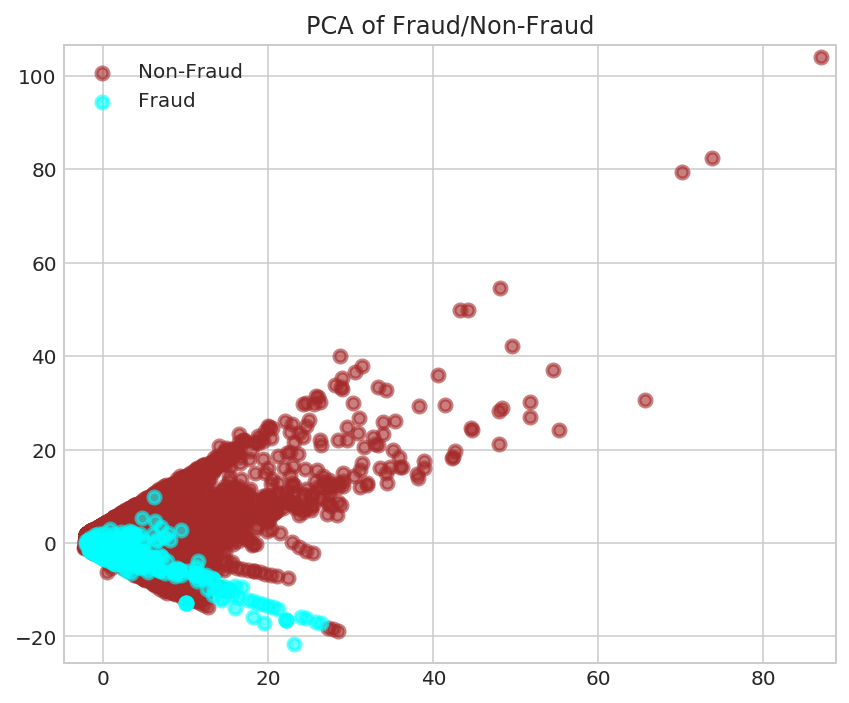

In [8]:
# 2-component PCA plot
    # PCA is sensitive to dimensional scales, thus the need to standardise matrix X
X_pca = copy.deepcopy(X_train)
y_pca = copy.deepcopy(y_train).reshape(-1, )

pca = PCA(n_components=2, random_state=seed)
X_r = pca.fit_transform(X_pca)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(6,5)); colors = ['brown', 'cyan']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.6, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Fraud/Non-Fraud')
plt.tight_layout(); plt.margins(0.02)

To illustrate this difficulty further, the PCA plot (of the training set) of the first 2 components show that frauds (minority) are highly intersecting in the area of the non-fraud (majority) cases. Reducing the level of misclassification will not be an easy task.

### Exploratory Data Analysis (EDA) - Training Set

With knowledge from the overview conducted previously, it is now time to perform some graphical analysis for the purpose of feature selection (i.e. which feature columns would help to predict whether a transaction is fraudulent or otherwise).

Since the aim is to model reality, a constraint is imposed into the EDA process. Only the training set will be evaluated for differences between fraud and non-frauds. The distributions of the fraud and non-fraud cases are first plotted to identify differences. If they are different, intuitively they ought to predict which transactions are fraudulent and which are not.

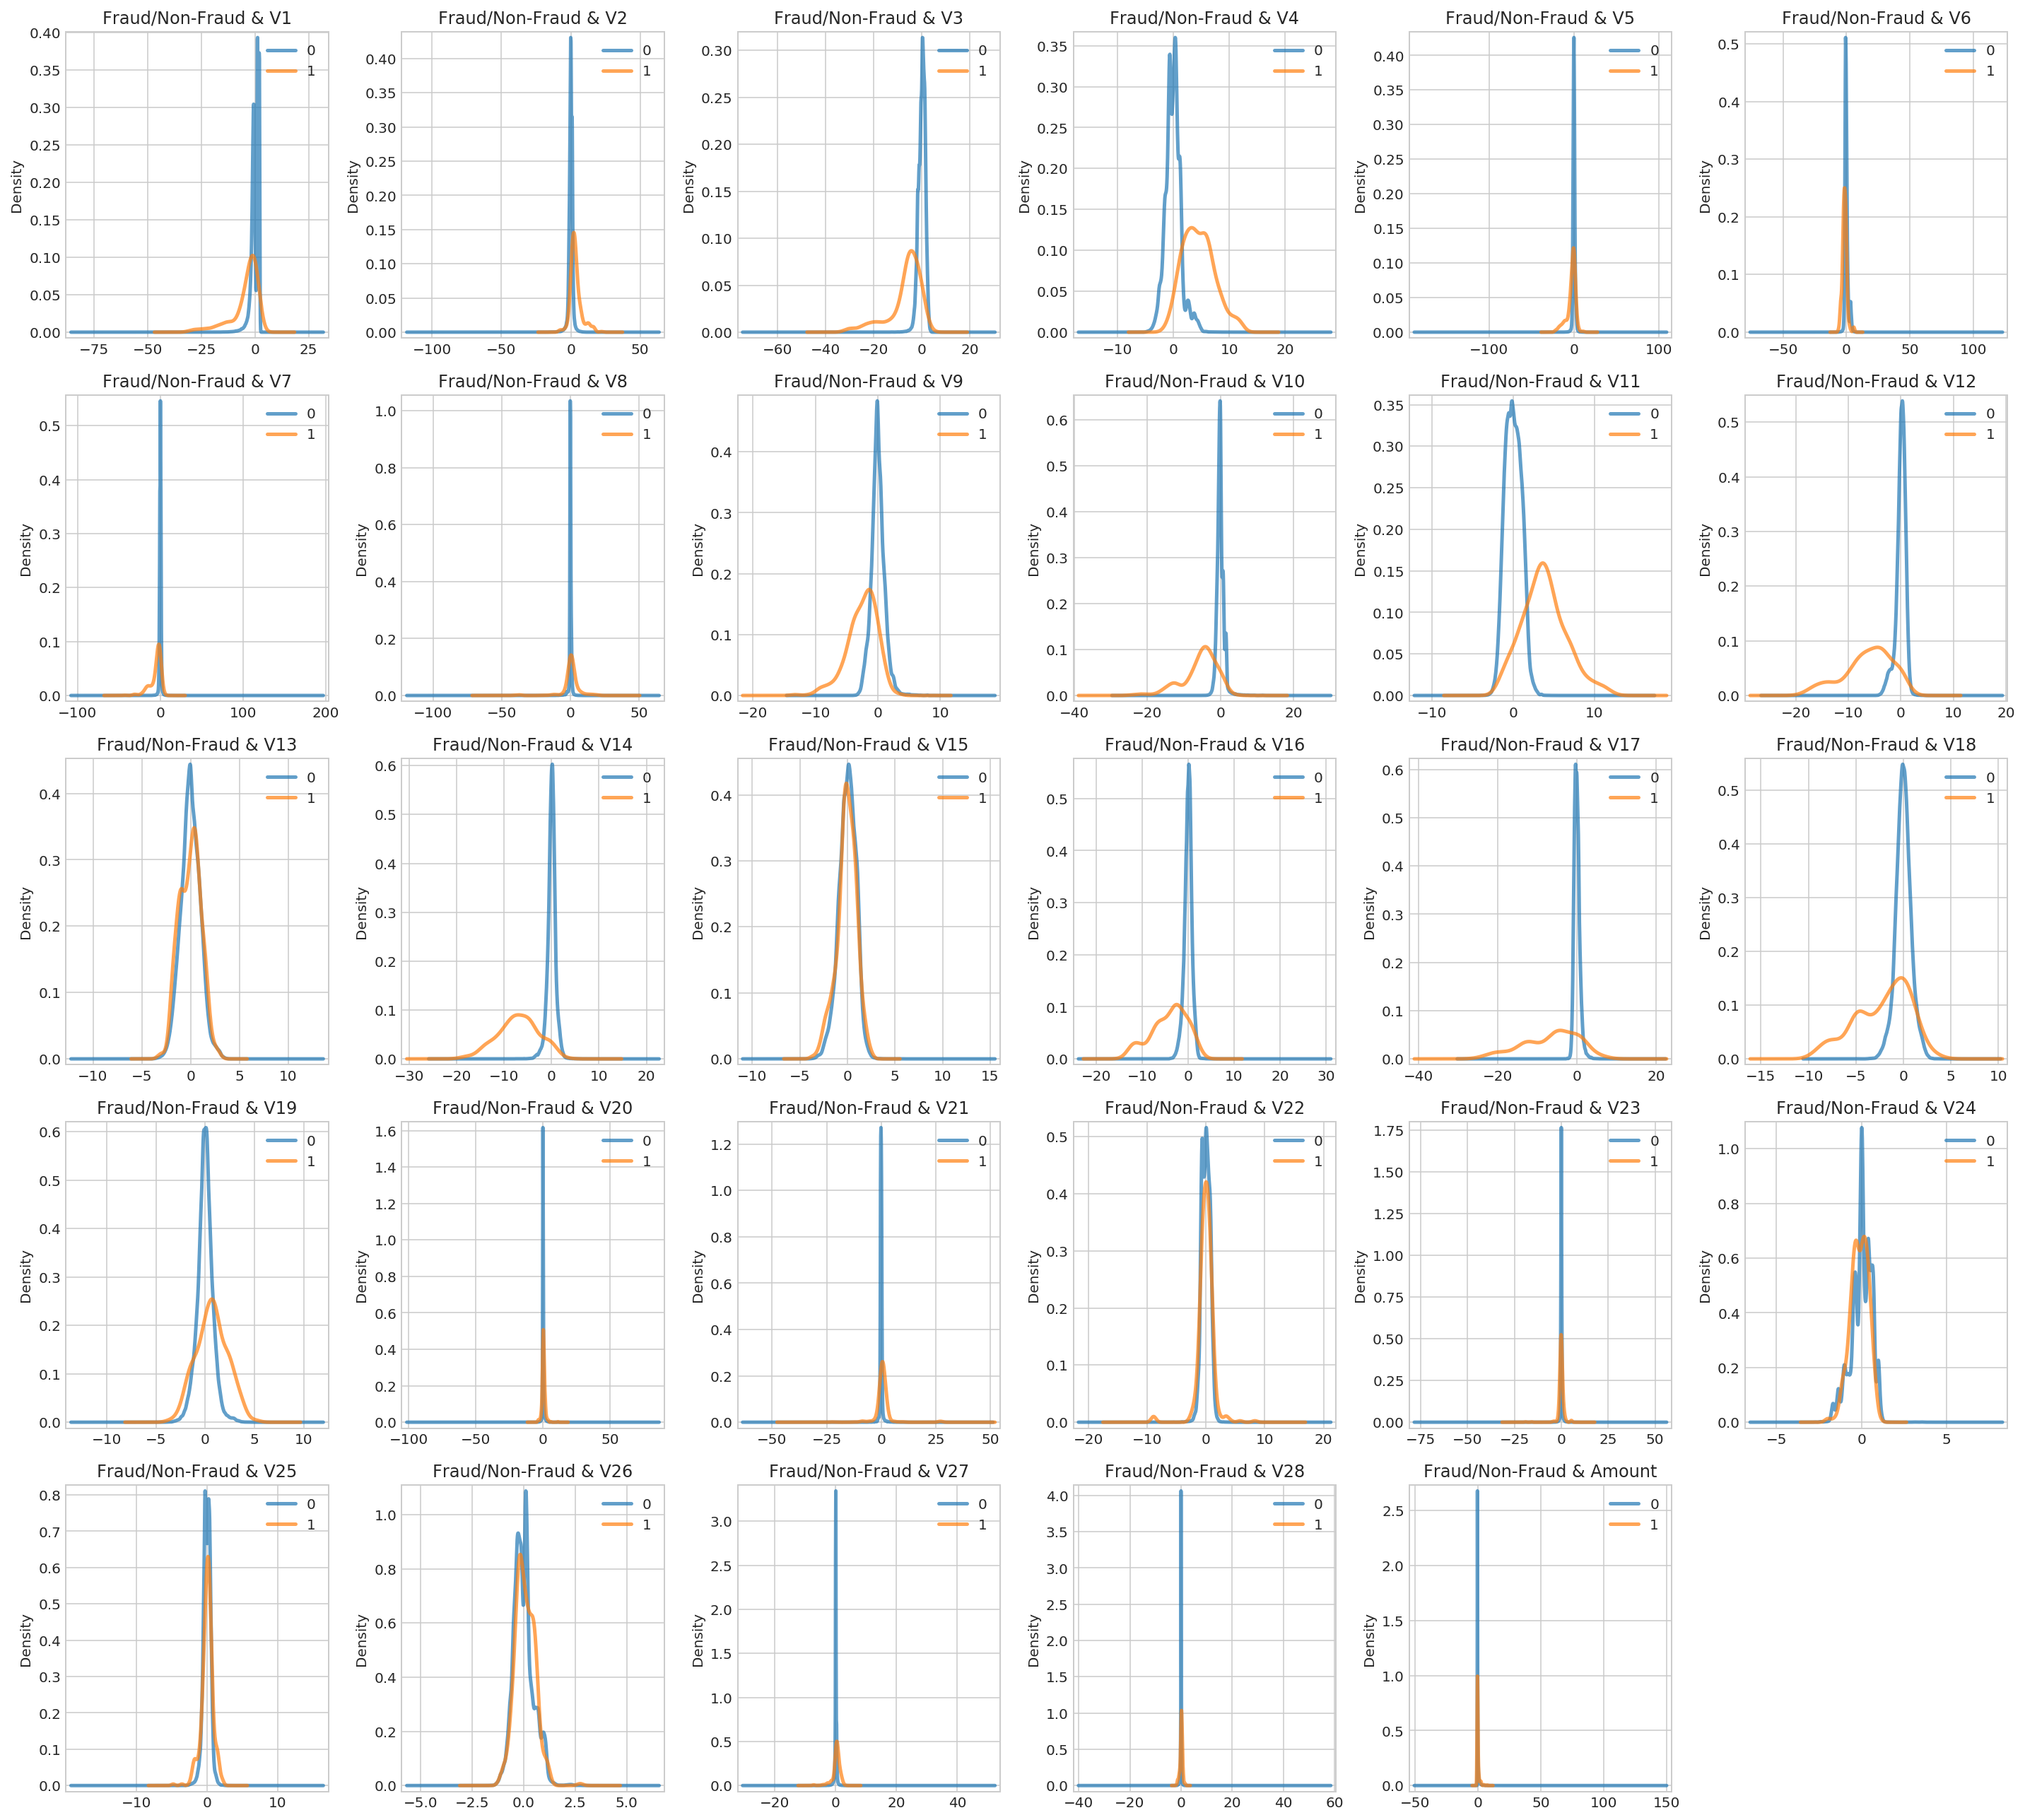

In [23]:
# Kernel Density Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,18))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(5, 6, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=0.7, legend='best', lw=2.5)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()    

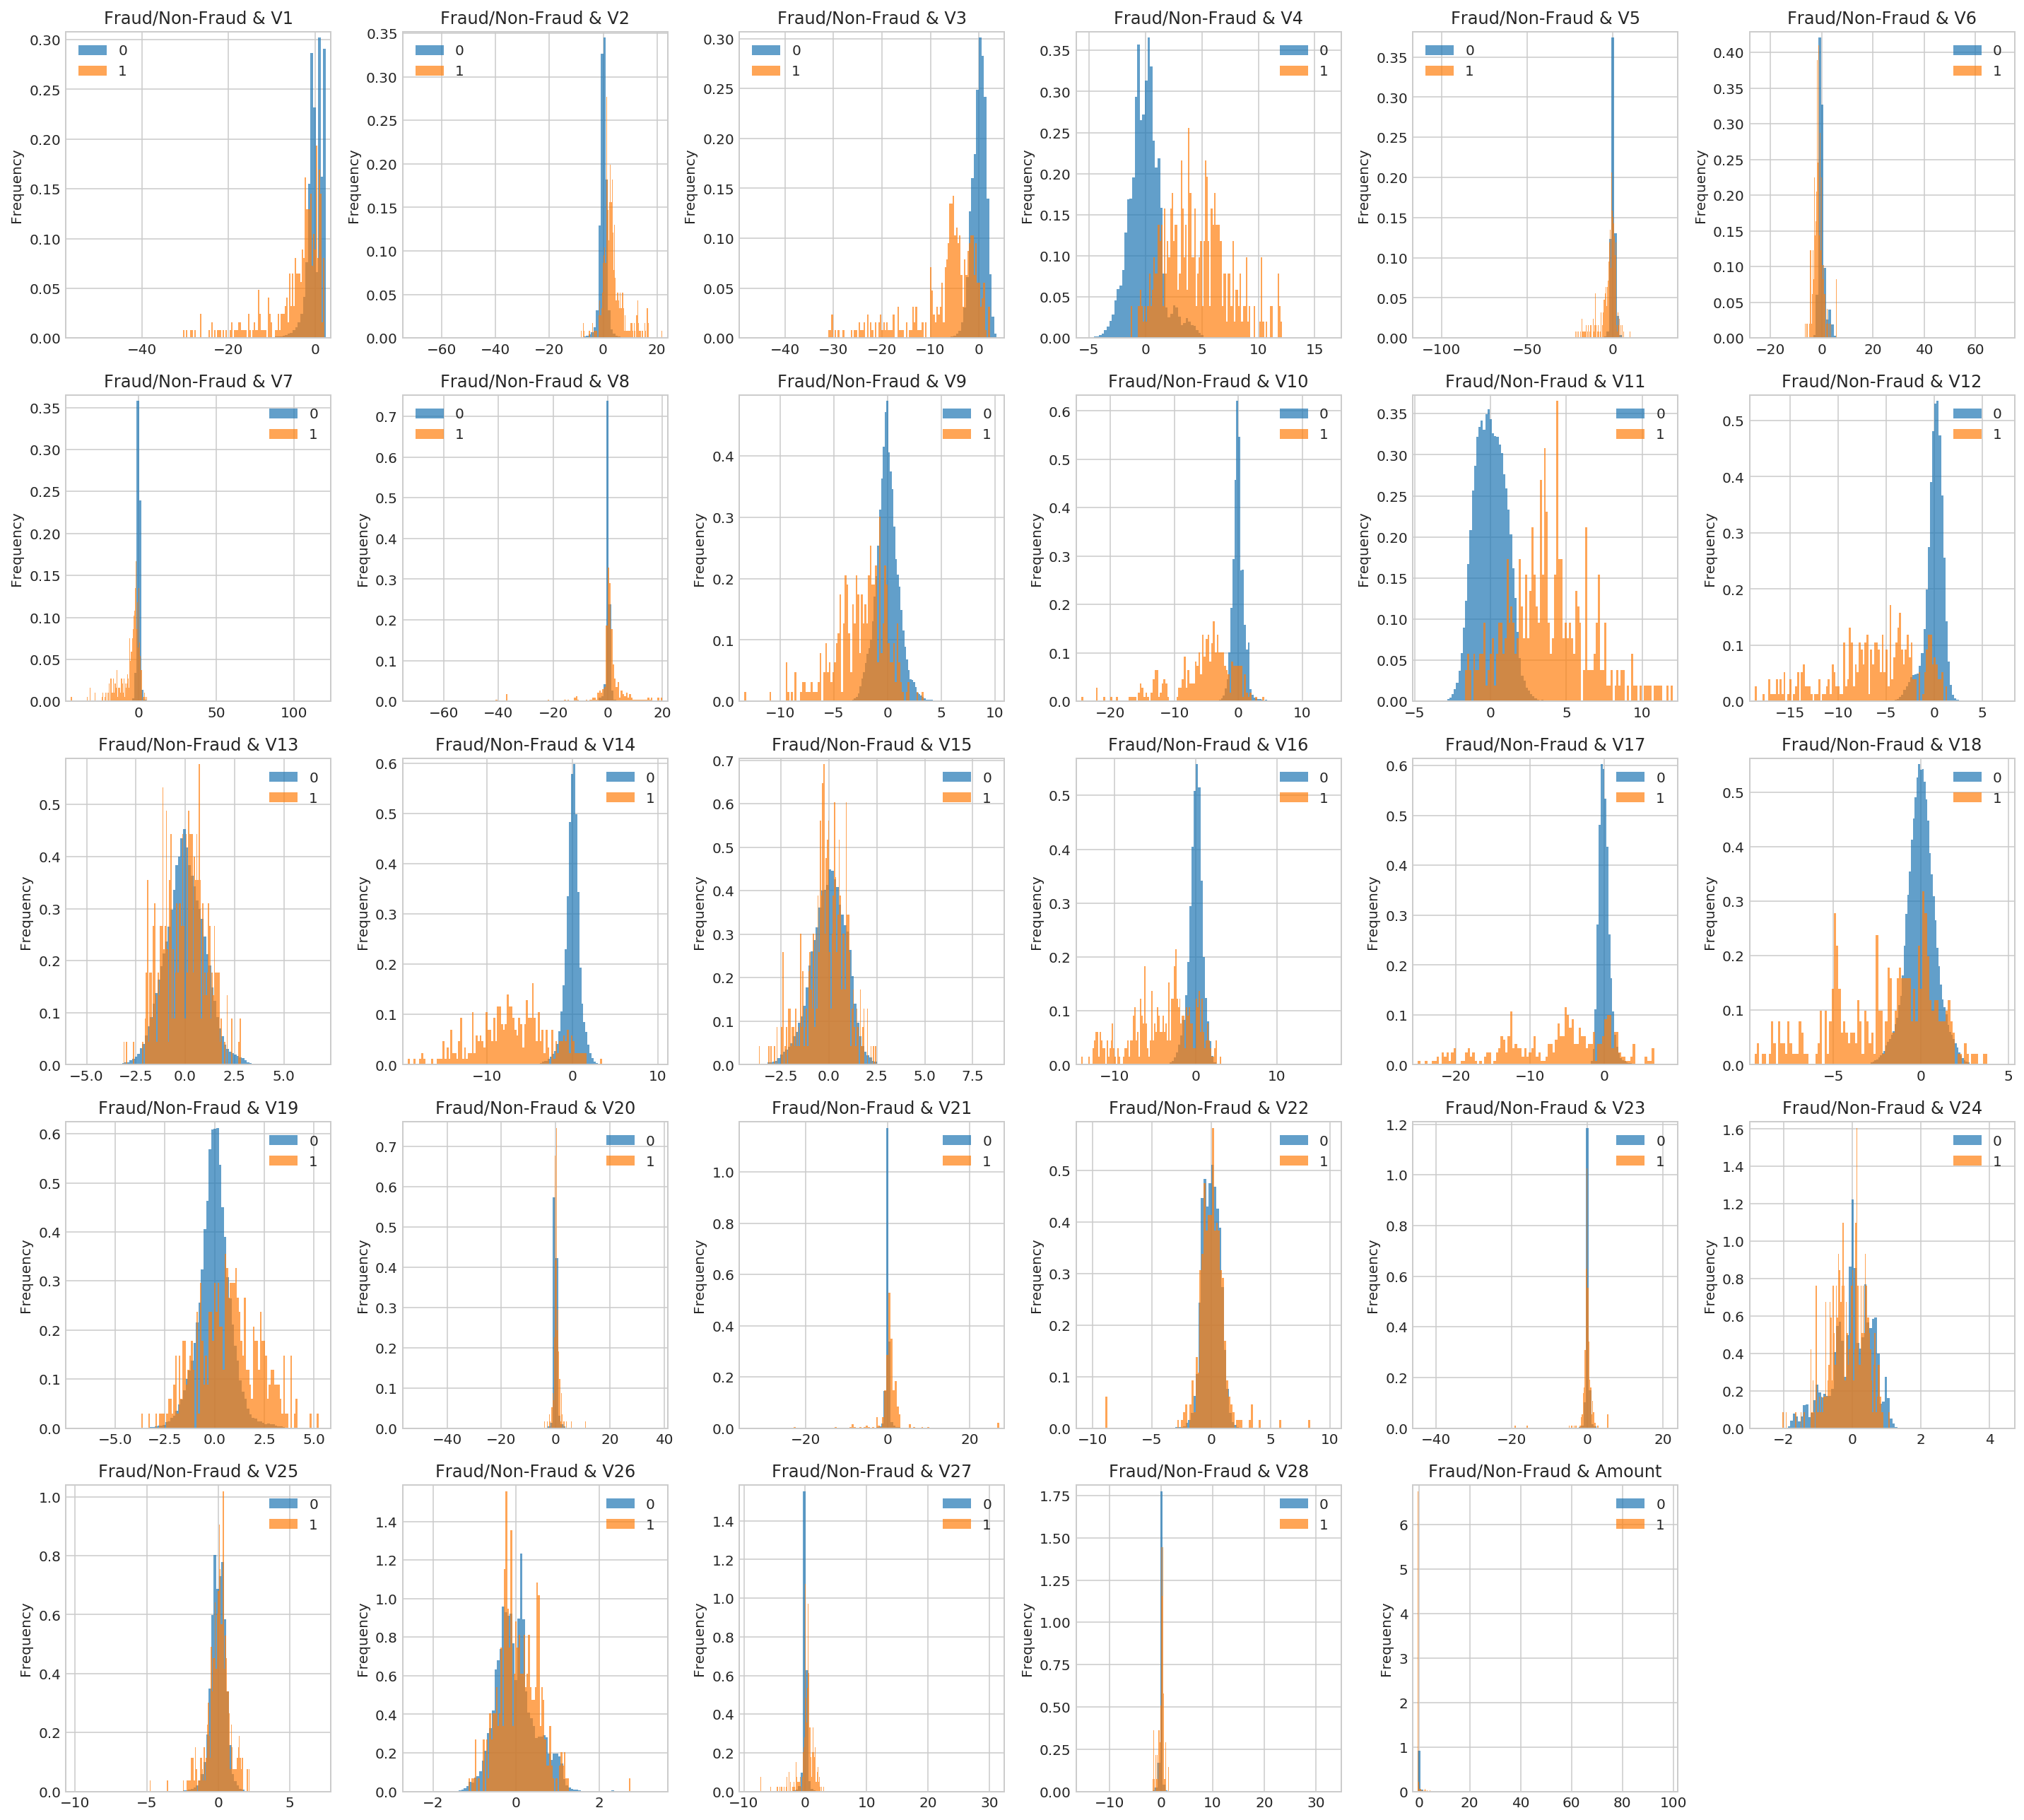

In [24]:
# Histogram Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,18))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(5, 6, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='hist', bins=100, alpha=0.7, 
                                           legend='best', normed=True)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()    

Based on the distribution graphs above, it appears that for certain features, the distribution of fraudulent cases are different from non-fraudulent ones. However, it would be too informal and presumptuous to make definitive judgements based on visual inspection.

For the sake of reaching a robust conclusion (on which features are important to distinguish normal transactions from fraudulent ones), equality of distribution tests shall be implemented. If there are little statistical differences between fraud and non-frauds for a particular feature, then this feature would be a poor predictor of fraud transactions.

In this case, the Wilcoxon Rank-Sum Test is chosen here since outliers were found in the data (in particular, 'Amount').

In [9]:
# Perform Wilcoxon Rank-Sum Test at 5% Level to determine feature relevance

# Keep results if needed later
wilcox_result = dict([])

for feat in X_cols:   
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    
    # Draw 300 samples (only 379 fraud data in training set, attempt to draw close to the hilt)
    random.seed(42)
    fraud_wilcox = random.sample(list(temp_df[temp_df['Class']==1][feat]), k=300)
    nonfraud_wilcox = random.sample(list(temp_df[temp_df['Class']==0][feat]), k=300)
    
    rank_sums, p_val_wilcox = stats.wilcoxon(fraud_wilcox, nonfraud_wilcox)
    
    if p_val_wilcox > 0.05:
        wilcox_result[feat] = ('No_Diff', p_val_wilcox)
        print('Feature "{}" failed to be rejected at 5% level with p-value {:.10f}'.format(feat, p_val_wilcox))
    else:
        wilcox_result[feat] = ('Diff', p_val_wilcox)
    
# Rank-Sum Test determined differences in classes within feature
wilcox_feat = [feat for feat in wilcox_result.keys() if wilcox_result[feat][0] == 'Diff']
print('\n', 'Wilcoxon Rank-Sum Relevant Features: ', wilcox_feat)
print('Total number of features selected: {}'.format(len(wilcox_feat)))

Feature "V13" failed to be rejected at 5% level with p-value 0.0973465482
Feature "V15" failed to be rejected at 5% level with p-value 0.8092477538
Feature "V22" failed to be rejected at 5% level with p-value 0.3224055980
Feature "V23" failed to be rejected at 5% level with p-value 0.7011952304
Feature "V26" failed to be rejected at 5% level with p-value 0.5115929524
Feature "Amount" failed to be rejected at 5% level with p-value 0.9531649675

 Wilcoxon Rank-Sum Relevant Features:  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V25', 'V27', 'V28']
Total number of features selected: 23


In [10]:
unselected_feats = list(set(X_cols).difference(wilcox_feat))
print('Unselected features: {}'.format(unselected_feats))

Unselected features: ['V22', 'V26', 'V15', 'Amount', 'V23', 'V13']


From the Wilcoxon tests, the null hypothesis for features 'V15', 'V22', 'V26', 'V13', 'V23' and 'Amount' fail to be rejected at 5% level - indicating that these features will not be useful in helping machine classifiers identify frauds.

Following, the scatter relations for the top 6 most correlated selected features were observed as shown below:

In [11]:
# Obtain the top 6 most correlated wilcoxon-selected variables' to observe their scatter pair plot relations

# Check for high correlations
wilcox_corr = X_train_df.drop(columns=['V15', 'Amount', 'V13', 'V26', 'V22', 'V23']).corr().abs()
wilcox_corr_pdSr = wilcox_corr.unstack()
wilcox_corr_pdSr_sort = wilcox_corr_pdSr.sort_values(ascending=False).to_frame()

# Top 6 correlated variable pairs
wilcox_corr_pdSr_sort.iloc[23:35:2, :].rename(index=str, columns={0:'pearson_rho'})

pearson_rho
V5 V7     0.030143
V6 V5     0.016899
V7 V3     0.016640
   V6     0.016007
V2 V1     0.015015
V1 V7     0.012172

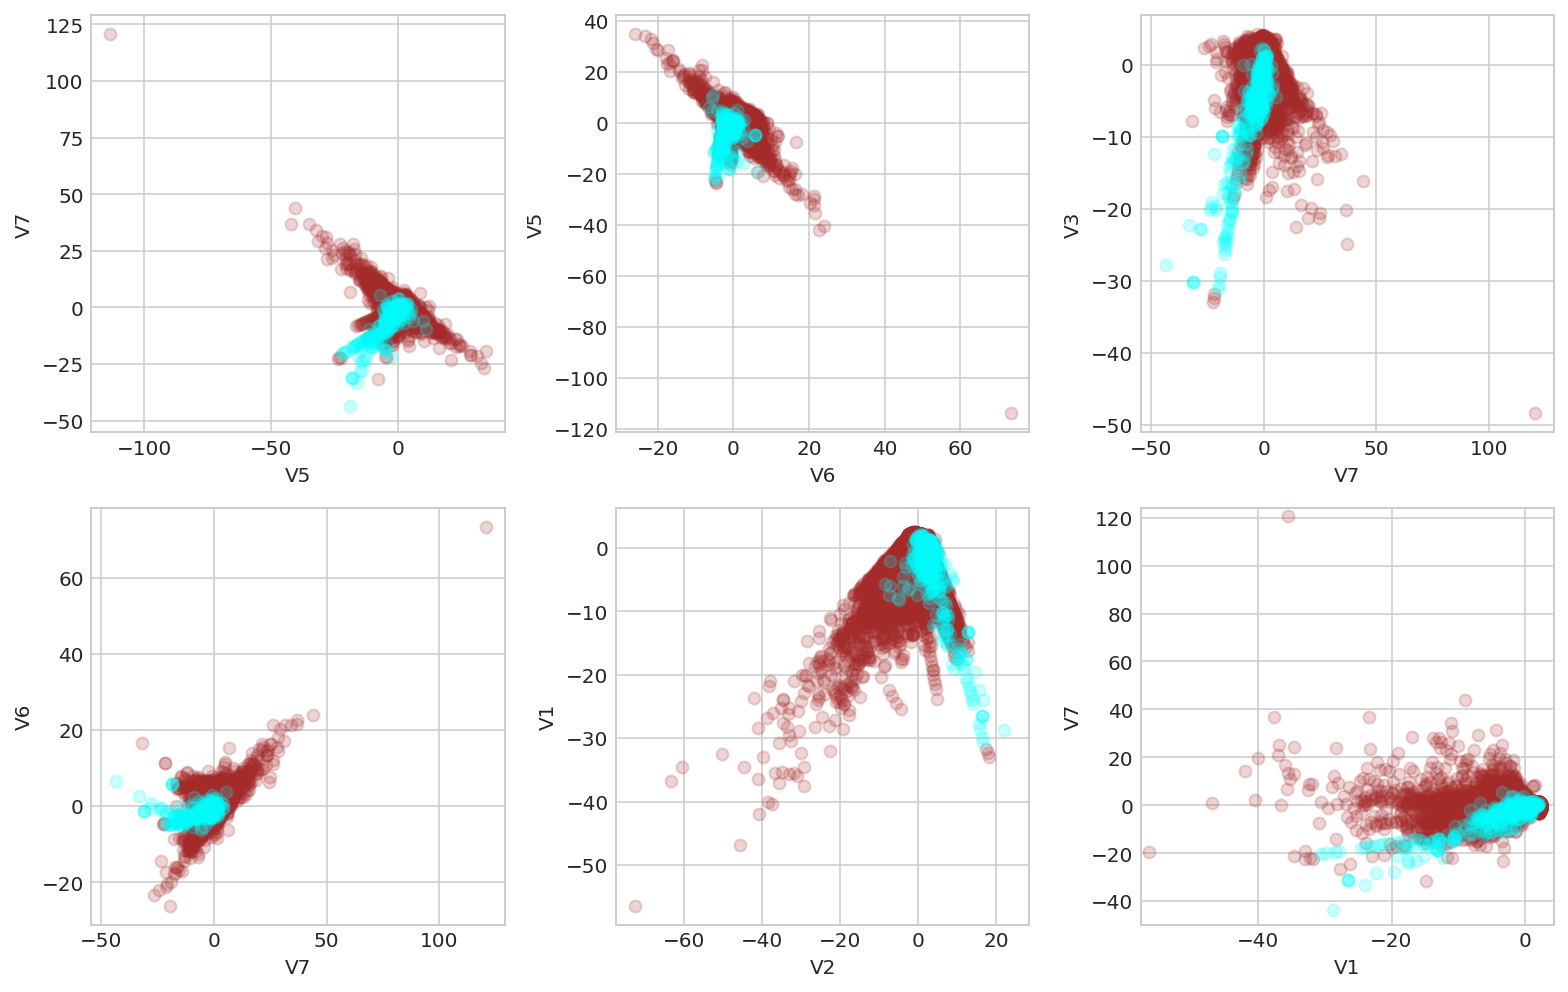

In [15]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(11, 7))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(2, 3, (plot+1))
    
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], 
                    group[1][corr_top6[plot][1]], 
                    c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0]); plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

Like the PCA plot in the overview section, fraudulent transactions are overlapping non-frauds heavily although (fortunately) not entirely. If the strategy is to upsample the minority class to assist algorithms in identifying frauds, it will not be unexpected to find high rates of misclassification in this dataset after the upsampling process.

To upsample, random uniform oversampling and synthetic minority oversampling techniques (SMOTE) were implemented.

### Establishing the Baseline

Before proceeding to perform upsampling on the data, the stochastic gradient descent classifier from 'scikit-learn' will be implemented throughout as the choice machine algorithm classifier. This will be implemented directly on the training set and validated using the test set and subsequently replicating the process again, except using the gridsearch feature additionally for some hyperparameters this time to see how well the model improves.

In [12]:
# Using default values except "penalty='elasticnet'"
# To preserve/remove meaningful/irrelevant features without absolute purging
sgd_clf = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Measure Start Time
start_time = time.time()

# Fit and obtain predictions
sgd_clf.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
y_hat = sgd_clf.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

pred_score = sgd_clf.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_test)
print('Prediction Score: ', pred_score, '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat), '\n')
print('Classification Report:', '\n', classification_report_imbalanced(y_test, y_hat))

Time elapsed to train:  0.35260605812072754
Prediction Score:  0.977612988399 

Confusion Matrix:  
 [[69505  1584]
 [   10   103]] 

Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.91      0.99      0.25      0.07     71089
          1       0.06      0.91      0.98      0.11      0.25      0.06       113

avg / total       1.00      0.98      0.91      0.99      0.25      0.07     71202



Without much tuning, the basic model performs unexpectedly decent. With a recall of 0.91 on the minority (fraudulent) class, only 9% of all flagged frauds were left undetected. Benchmarking against a [reported 58% of successful credit card frauds](https://www.lexisnexis.com/risk/downloads/assets/true-cost-fraud-2016.pdf), the baseline results are capable of detecting 91% of frauds, beating the minimal expectation of 42%.

Unfortunately this comes with its own caveats. The level of misclassification is substantial, leaving the precision of the classifier on minority class at 6%. If the aim is to increase the recall on identifying frauds, intuitively the precision on classifying frauds is likely to fall. To extend the baseline, a gridsearched version was implemented to evaluate for improvements.

In [13]:
# Measuring time taken for grid searching the optimal parameters
sgd_params = {'loss':['hinge', 'log', 'modified_huber', 'perceptron'],
              'penalty':['l1', 'l2', 'elasticnet'],
              'alpha':np.logspace(0.0001, 5, 5),
              'l1_ratio':list(np.linspace(0.0001, 1.0, 20))+[0.15],
              'random_state':[42], 
              'n_jobs':[-1],
              'eta0':[0.0001],
              'class_weight':['balanced']}
sgd_gridsearch = GridSearchCV(SGDClassifier(), sgd_params, cv=5, verbose=1, n_jobs=-1)

# Measure Start Time
start_time = time.time()
sgd_gridsearch.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_hat_grid = sgd_gridsearch.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())
pred_score_grid = sgd_gridsearch.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_test)
print('Prediction Score: ', pred_score_grid, '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat_grid), '\n')
print('Classification Report:', '\n', classification_report_imbalanced(y_test, y_hat_grid))

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed: 25.1min finished


Time elapsed to train:  1505.3255302906036
Prediction Score:  0.999353950732 

Confusion Matrix:  
 [[71071    18]
 [   28    85]] 

Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.75      1.00      0.91      0.84     71089
          1       0.83      0.75      1.00      0.79      0.91      0.81       113

avg / total       1.00      1.00      0.75      1.00      0.91      0.84     71202



In [14]:
# Print best parameters used in 'GridSearchCV'
print(sgd_gridsearch.best_params_)

{'alpha': 316.26417517967889, 'class_weight': 'balanced', 'eta0': 0.0001, 'l1_ratio': 0.0001, 'loss': 'modified_huber', 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42}


While recall on fraud cases has fallen, the precision in accurately identifying frauds has risen. This heightened precision potentially reduces expenditures, particularly manual reviews to businesses. In total, this simple gridsearching process took approximately half an hour to complete.

_Using reported figures from the 2016 Lexis Nexis True Cost of Fraud Study report and other various sources and suppose the following:_
- _This algorithm is the only line of defence against frauds_
- _Approximately 42-47% of transactions flagged as frauds are sent for [manual review](https://www.lexisnexis.com/risk/downloads/assets/true-cost-fraud-2016.pdf)_
- _The cost of manual investigation is between [40-70](https://www.quora.com/How-much-does-it-cost-issuing-banks-to-investigate-a-credit-card-fraud-case) dollars_
- _From above, the average cost per case of fraud is on average \$293.31_
- _The benchmark cost of frauds to the business is on average 1.47% as a percentage of the business' revenue applies to the dataset. Then the institution which provided this dataset can have its revenue reversed calculated_
    - _This is further based on the assumption that this cost was interpreted as costs attributed from fraudulent transactions only and does not contain any fraud mitigation and management expenditures yet_

_Then the cost of fraud, accounting for manual review and the cost of false negatives (frauds which failed to be identified) reduces to between 0.35-0.40% as a percentage of revenue when the algorithm above is implemented._ <br>

_This is computed with additional stringent assumptions that during the manual review processes, the possibility which all of the manually reviewed investigations are false positives (incorrect flags) was considered. Thus no benefits can be brought about by manual reviews. Also, true positives that were verified by other means than through manual reviews were assumed to have negligible costs._

#### Forward & Onward
Following the results of the baseline performances, SMOTE and uniform oversampling were implemented to generate more artificial fraudulent transactions with the aim of improving the classifier's precision and recall on the minority (fraud) cases. This result is then compared to using modern deep learning methodologies. Generative models, specifically adversarial networks (GAN), were tested to establish an understanding on whether synthetic data generated from these deep learning methods can improve fraud detection.

### Non-Deep Learning Methods vs. Generative Adversarial Networks

_**Random (uniform) sampling and Synthetic Minority Oversampling Technique (SMOTE) in brief**_

To reduce the cost of manual reviews and the fraction of successful frauds, algorithms will need to accurately classify whether a transaction is fraudulent or not. Given a dataset of features associated with fraudulent and benign transactions, frauds could be predicted based on training machine models on these historical data characteristics.

Unfortunately, models tend to function poorly in the face of highly imbalanced datasets. In the context of pecuniary transactions, thousands of transactions happen on a daily basis for instances on e-Commerce platforms and naturally banking transactions. As a percentage of total transactions, frauds constitute only _0.173%_ in the dataset used.

To manage this extreme level of imbalance, either the minority class is upsampled, the majority is downsampled or a combination of both. Illustrating with the first scenario, model instances such as SMOTE and random uniform oversampling were implemented.

> In uniform random oversampling methods, there is a risk of overfitting the dataset because observations in the dataset are repeatedly duplicated. As training is conducted on the artificially inflated dataset, these duplicates may then be over represented which may not be representative of the underlying feature distributions of the minority class(es).

> SMOTE and variations of it chiefly introduce random noises to the actual observed data points in order to generate new data points. In this case, the likelihood of overfitting to the actual dataset is lower than random oversampling. However, this comes with caveats. With the inclusion of noise, it is unknown how this would adversely affect the features' distribution patterns. Suppose the features of the minority class are already representative of reality's distribution patterns, generating synthetic datapoints may shift the distribution in unpredictable ways that no longer reflect reality and or the dataset.

_**Results from random uniform oversampling on the minority class**_ <br>
To evaluate the performance of random oversampling, the 'RandomOverSampler' from module ['imblearn'](http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html) was implemented to upsample the minority (fraud) class' observations. As the training set contains only 379 cases of fraud, the number of frauds were augmented by an addition of 5000 observations, raising the number of frauds to 5379.

In [15]:
# Classifier
sgd_clf = SGDClassifier(penalty='elasticnet', random_state=42, class_weight='balanced')

# Random uniform oversampling
rand = RandomOverSampler(ratio={1:5379}, random_state=42)
    # 'imblearn' upsamples to 5000 observations - 4621 generated + 379 original; to augment by 5000, 'ratio={1:5379}'
pipeline_rand = pipeline.make_pipeline(rand, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_rand.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_rand = pipeline_rand.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_rand), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_rand))

Time elapsed to train:  0.3977847099304199
Confusion Matrix:  
 [[68543  2546]
 [   10   103]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.91      0.98      0.20      0.04     71089
          1       0.04      0.91      0.96      0.07      0.20      0.04       113

avg / total       1.00      0.96      0.91      0.98      0.20      0.04     71202



While the data augmented via random uniform oversampling produced a high recall on frauds (0.91), its precision remains poor at 0.04 which is lower than the regular baseline at 0.06. While small in percentage, the absolute number of false positives amount to significant costs incurred through manual reviews.

This pushed the cost as percentage of revenue to at least 1.65% to as high as 3.13% which is much higher than doing nothing which would have yield a cost of 1.47%.

_**Results from SMOTE-ing on the minority class**_ <br>
'SMOTE' from ['imblearn'](http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html) was implemented next to upsample the minority (fraud) class observation. Again, an additional 5000 synthetic fraud observations were generated on top of the existing real frauds.

In [16]:
# SMOTE
smt = SMOTE(ratio={1:5379}, random_state=42, n_jobs=-1)
pipeline_smt = pipeline.make_pipeline(smt, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_smt.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_smt = pipeline_smt.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_smt), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_smt))

Time elapsed to train:  0.5044991970062256
Confusion Matrix:  
 [[63691  7398]
 [    9   104]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.90      0.92      0.95      0.12      0.02     71089
          1       0.01      0.92      0.90      0.03      0.12      0.01       113

avg / total       1.00      0.90      0.92      0.94      0.12      0.02     71202



Via SMOTE, the degree of misclassification worsens from the previous. For a relatively similar level of recall on the minority class, misclassification rose by almost 5000 observations. The cost has now risen to between 4.47-8.67%!

With such results, it reinforces the caveat noted earlier, SMOTE potentially distort the underlying feature distributions of the minority class such that these synthetic datapoints no longer resemble the true data adequately for accurate classification.

_**Results from SMOTE-ing with Tomek Linkages on the minority class**_ <br>
One possibility of misclassifications may be due to overlapping observation points in the data. Therefore, the Tomek Linkage undersampling process was next implemented after SMOTE to evaluate for classification improvements.

In [17]:
# SMOTE with Tomek Linkages (removing overlaps)
tl = TomekLinks(ratio={1:5379}, random_state=42, n_jobs=-1)
smotetl = SMOTETomek(random_state=42, tomek=tl, smote=smt, n_jobs=-1)
pipeline_smotetl = pipeline.make_pipeline(smotetl, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_smotetl.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_smotetl = pipeline_smotetl.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_smotetl), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_smotetl))

/home/Envireum/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/Envireum/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Time elapsed to train:  62.56735682487488
Confusion Matrix:  
 [[69206  1883]
 [   10   103]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.91      0.99      0.23      0.06     71089
          1       0.05      0.91      0.97      0.10      0.23      0.05       113

avg / total       1.00      0.97      0.91      0.99      0.23      0.06     71202



Fortunately, the results improved when Tomek Linkages where used to remove any potential overlaps between fraud and non-fraud cases. In fact, the results are significantly better in comparison to the random uniform upsampling of the minority (fraud) class. The cost involved stands between 1.26-2.37% as a percentage of revenue. Nonetheless, this performance is not as satisfactory since the gridsearched baseline still performs the best out of all the techniques explored so far.

The changes in the top 6 pairs of correlated features were plotted additionally below to visualise changes to the data's characteristics.

In [18]:
# Obtain resampled data for plotting
X_rand, y_rand = rand.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_rand = np.concatenate((X_rand, y_rand.reshape(-1, 1)), axis=1)
rand_df = pd.DataFrame(data=arr_rand, columns=(wilcox_feat + ['Class']))

X_smt, y_smt = smt.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_smt = np.concatenate((X_smt, y_smt.reshape(-1, 1)), axis=1)
smt_df = pd.DataFrame(data=arr_smt, columns=(wilcox_feat + ['Class']))

X_smotetl, y_smotetl = smotetl.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_smotetl = np.concatenate((X_smotetl, y_smotetl.reshape(-1, 1)), axis=1)
smotetl_df = pd.DataFrame(data=arr_smotetl, columns=(wilcox_feat + ['Class']))

/home/Envireum/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/Envireum/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


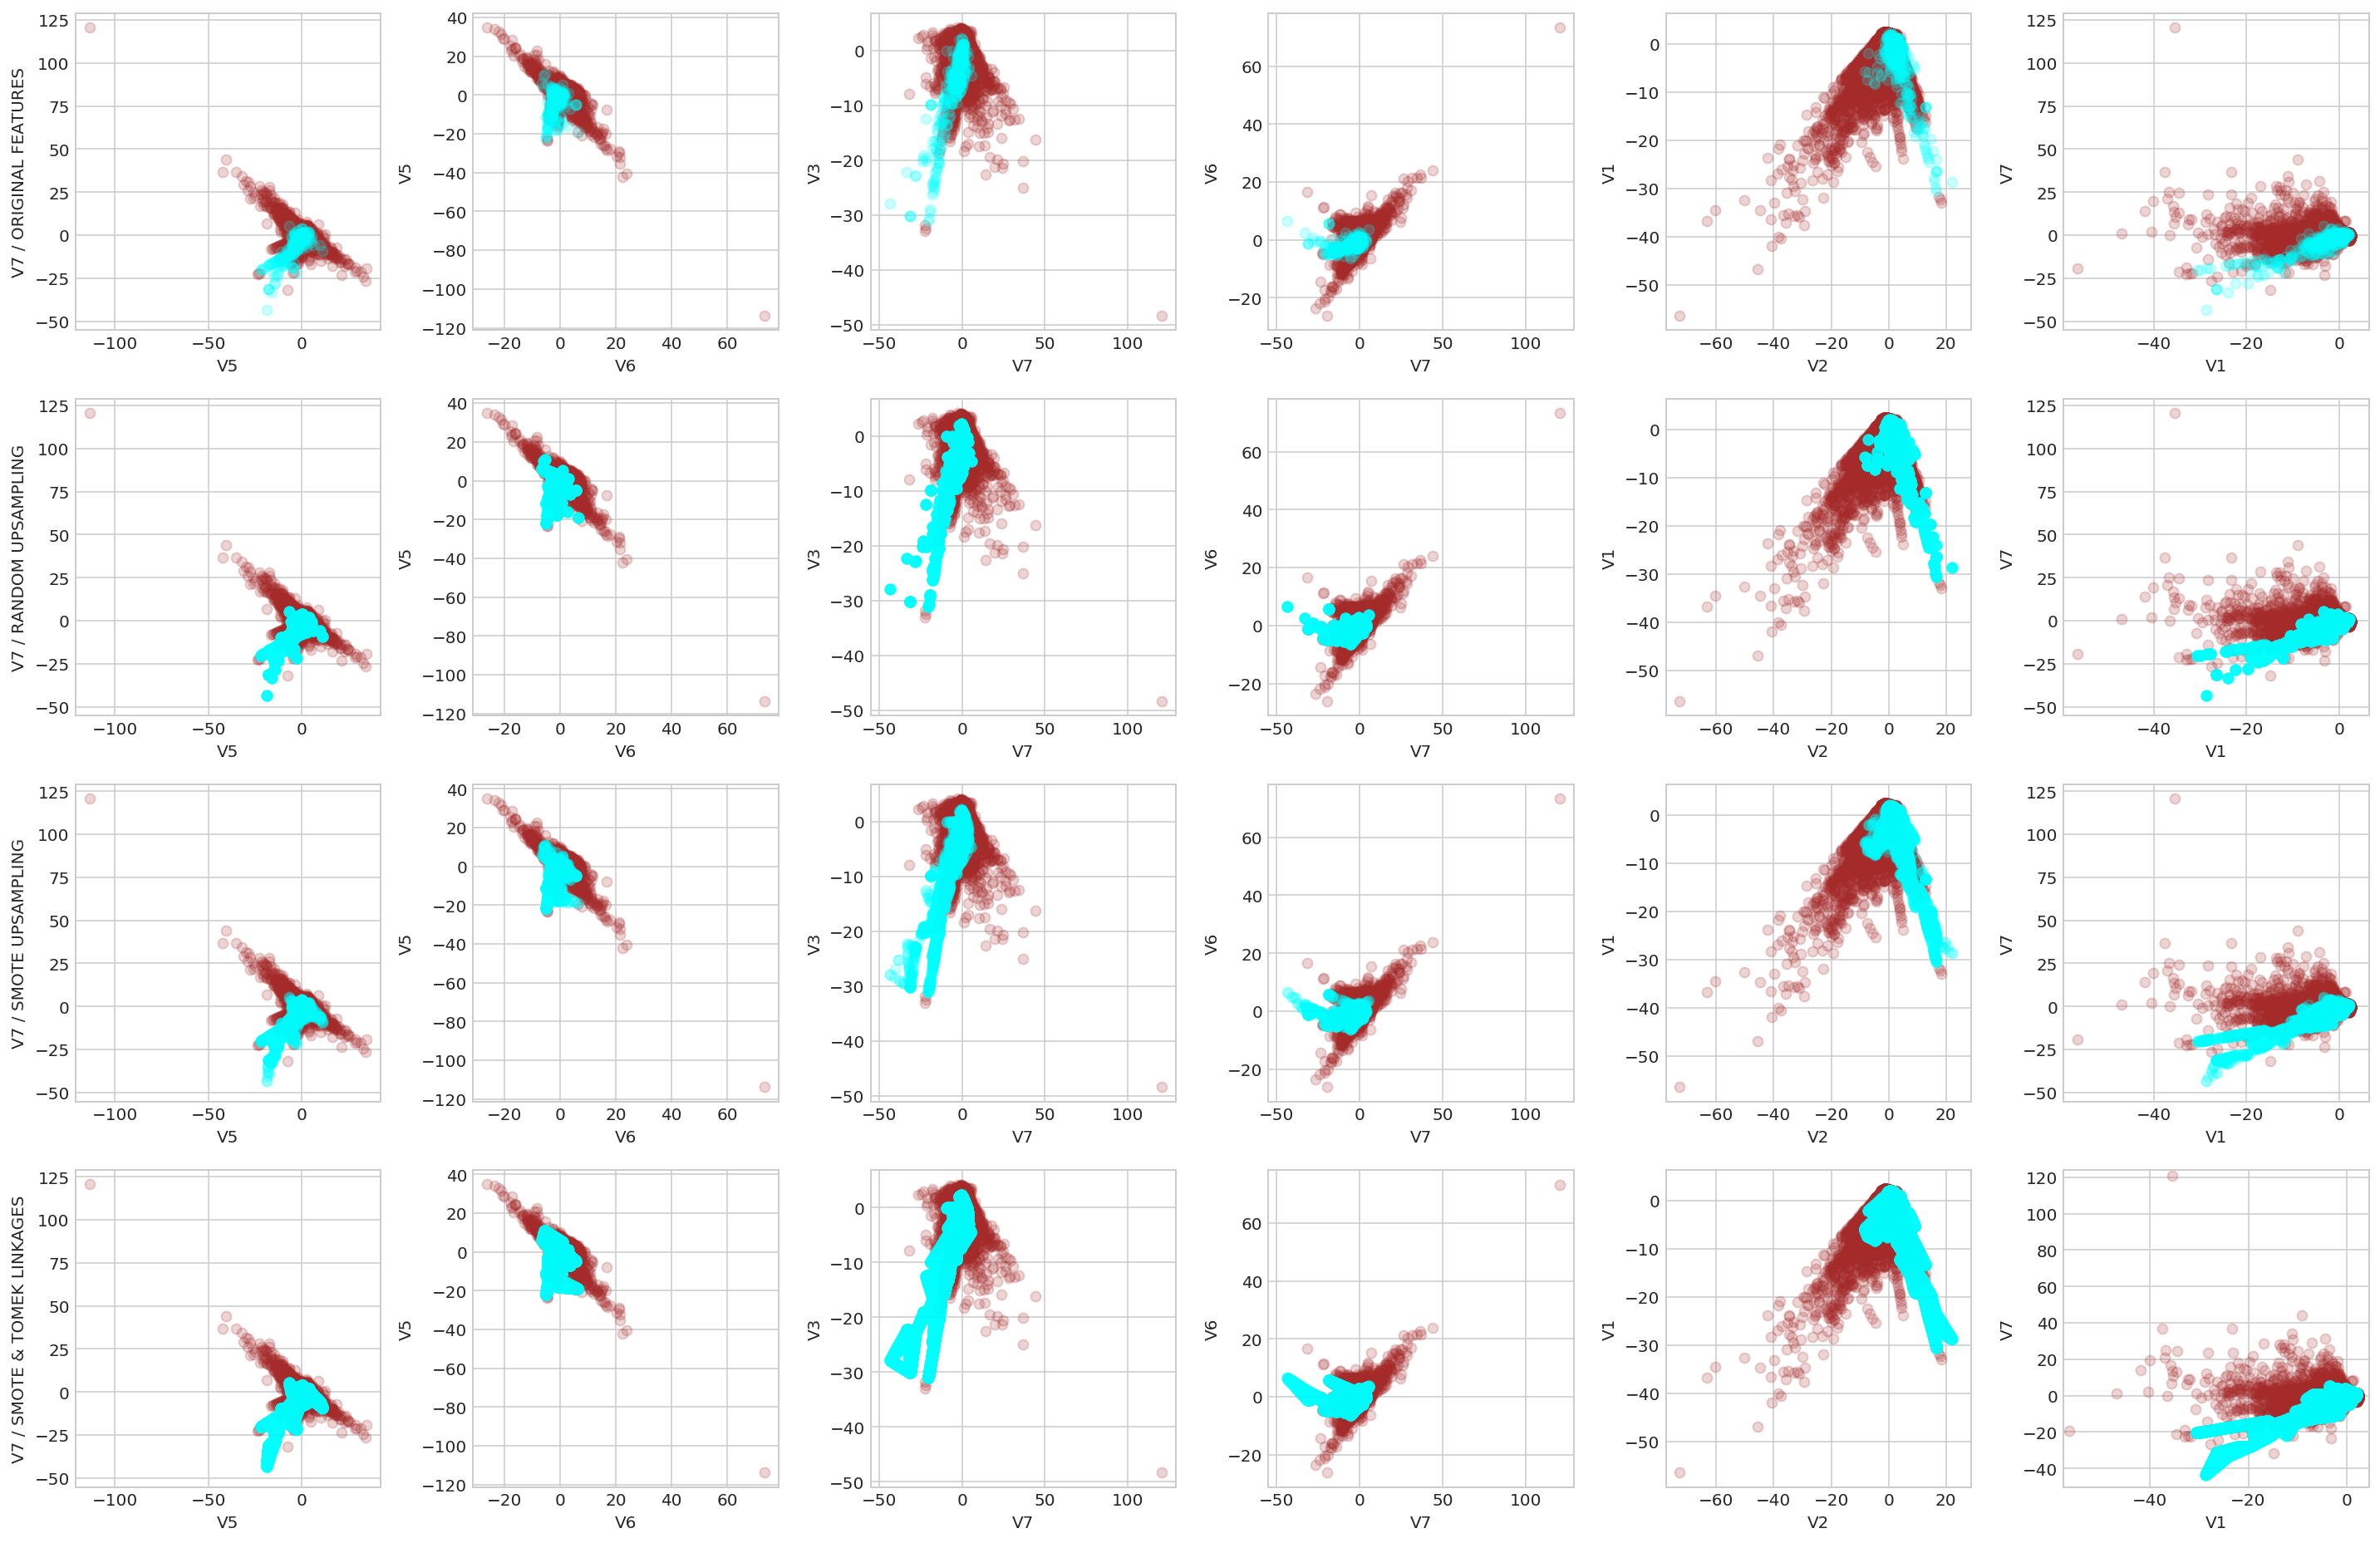

In [19]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(20, 13))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(4, 6, (plot+1))
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / ORIGINAL FEATURES')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+7))
    for group, color, label, in zip(rand_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / RANDOM UPSAMPLING')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+13))
    for group, color, label, in zip(smt_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / SMOTE UPSAMPLING')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+19))
    for group, color, label, in zip(smotetl_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / SMOTE & TOMEK LINKAGES')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

From the diagrams, random uniform upsampling darkens spots with existing data while SMOTE techniques appear to generate additional noises. Resultantly, the scatter patterns are sharply altered relative to random upsampling. Unsurprisingly, data augmented with SMOTE fared the worst relative to the regular baseline while random oversampling being the second.

These diagrams thus illustrate the points aforementioned. Random uniform sampling is likely to cause overfitting of the classifier onto the training dataset such that it fares worse when validating its performance with unseen data. On SMOTE techniques, they introduce unwanted noises that skew the underlying distributions of the features to the point it 'confuses' the classifier, hence resulting in its poorer performance.

_Garbage In, Garbage Out..._

_**General conclusions about vanilla sampling techniques - random & SMOTE sampling**_

It may be argued that minimal efforts were put into gridsearching for the optimal parameters. However, notice that in SMOTE-TL, just inputing default parameters (apart from 'n_jobs=-1' to parallelise the operation and 'random_state=42' for reproducibility) took approximately 1 minute. Even earlier, the gridsearched baseline required almost half an hour of gridsearching for that few hyperparameter options specified. Had gridsearch been implemented into the sampling as well as the classification process, the amount of time could potentially be exponential, or frequently coined - a combinatorial explosion!

Moreover, gridsearching is akin to a brute force method of obtaining optimal values for the hyperparameters. In this case, it is not unreasonable to postulate that the classifier would have been overfitted to the test set as well.

When unseen fraudulent transactions arrive, the classification models may not be capable of identifying them at all. To address these issues mentioned (though not exhaustive), Generative Adversarial Networks (GAN) is proposed here to overcome the problems the sampling methods above potentially bring. The advantage of GANs is that the underlying feature distributions is understood by the network via a min-max game between the generator and discriminator network in GANs.

### Generative Adversarial Networks
_**Why GANs in data augmentation**_

First proposed by [Ian Goodfellow and colleagues](https://arxiv.org/abs/1406.2661), the vanilla GANs' implementation comprises of two networks, the generator and discriminator, which compete against each other in a min-max optimisation process. The highly used case example would be counterfeiting banknotes. The generator is the counterfeiter while the discriminator is the investigator trying to figure out whether the banknotes synthesized by the generator are authentic. Both network receives feedback from each other and improve in reproducing near genuine banknotes and being a better investigator over time.

In greater technical detail, the network is defined by the following equation which the generator and discriminator attempt to optimise:

$$ \underset{G}{\text{min }} \underset{D}{\text{max }} V(D, G) = E_{x\text{~P}_{data}(x)}[logD(x)] + E_{z\text{~P}_{z}(z)}[log(1 - D(G(z)))] $$

---

_When training the generator,_
$$ \underset{G}{\text{min}}V(\bar{D}, G) = E_{x\text{~P}_{data}(x)}[logD(x)] + E_{z\text{~P}_{z}(z)}[log(1 - D(G(z)))] $$

_its optimal state is achieved when_
$$ logD(x) \to -\infty \text{   when   } D(x) \to \text{   0   } $$

$$ log[1-D(G(z))] \to -\infty \text{   when   } D(G(z)) \to \text{   1   } $$

---

At each particular epoch, the generator draws 'noises' from a prior distribution. As it receives feedback from the discriminator in progressive epochs, the generator learns to map this prior distribution to the true (if not the posterior) distribution of the data inputted better.

---
_For the discriminator,_
$$ \underset{D}{\text{max}}V(D, \bar{G}) = E_{x\text{~P}_{data}(x)}[logD(x)] + E_{z\text{~P}_{z}(z)}[log(1 - D(G(z)))] $$

_its optimal state is achieved when_
$$ logD(x) \to \text{   0 when   } D(x) \to \text{   1   } $$

$$ log[1-D(G(z))] \to \text{   0 when   } D(G(z)) \to \text{   0   } $$

---

Eventually, the generator learns to adjust the synthetic data's distribution to resemble more like the real data's distribution while the discriminator becomes more adept at adjusting the boundary which separates the differences between the generated data and the real data's distribution. 

At an optimal state, the divergence between the generated and the real data's distribution is 0 - technically, the Kullback-Leibler Divergence measure is optimised to 0, the state when the probability density function of the generated and the real data are the same.

![](gan5.png)_Source: https://ireneli.eu/2016/11/17/deep-learning-13-understanding-generative-adversarial-network/_

The figure above illustrates how the adversarial network functions. The discriminator's decision boundary function is indicated with blue dotted lines, black dotted lines for the real data's probability density function _(pdf)_ and the generated data's pdf by green lines.

From panel (a) to (b), the discriminator learns to differentiate real and generated data and adjusts the boundary function accordingly. Anything beyond/to the right of the blue dotted line would consequently be identified as generated data.

From panel (b) to (c), upon receiving this feedback, the generator then knows that it has to adjust the generated data's distribution such that they lie as far to the left of the blue sigmoid curve. The generator next aims to map the prior values closer to the left of the decision boundary, approximating to the real data's distribution (black dotted) during this process.

Subsequently, the discriminator receives feedback from how the generator has optimised and adjusts its decision boundary accordingly. This process repeats until an optimal state is achieved.

After multiple epochs of optimisations, the theoretical optimum is reached when both the generated and real data's distributions are identical, depicted in panel (d). At this juncture, the blue dotted curve is now a horizontal line (which is 0.5), indicating that the discriminator can no longer differentiate which data is generated or real. For some data drawn, the discriminator has a probability of 0.5 to identify the data incorrectly. That is, there is no difference from a guess whether the data is real or generated at the optimal state of the adversarial network.

In sum, training of a GAN is completed when the following equations are satisfied:

$$ P_{data}(x) = P_{g}(x) = 0.5  \to  KL(P_{data}(x) \text{  ||  } \frac{P_{data}(x)}{P_{data}(x) + P_{g}(x)} = 0 $$

$$ D_{G}^*(x) = \frac{P_{data}(x)}{P_{data}(x) + P_{g}(x)} = \frac{0.5}{0.5 + 0.5} = 0.5 $$

---

The only drawback of using classical GANs is that they tend to be delicate to train. During a training epoch, either the discriminator or the generator have the ability to overpower the other which could have rendered either network incapable of learning to generate better synthetic data or adjust the decision boundary.

Further on that note, mode collapses happen when the generator is capable of fooling the discriminator by generating data that falls within a small segment of the real data's distribution. With reference to the diagrams above, the generator repeatedly generates data points to the left of the sigmoid curve only.

When that happens, the generator is no longer capable of generating synthetic data close to the real data distribution since creating samples that resemble a small segment of it is sufficient to fool the discriminator. The generator no longer explores the full possibilities of generated data variants and hence 'overfits' to a segment of the real (posterior) distribution.

_**Advancements in GAN - Wasserstein**_

One of the prominent solution to training GANs proposed is the Wasserstein GAN (WGAN) by Arjovsky, Chintala & Bottou (2017). In it, the discriminator is modified into a critique of the generated data's distribution. Rather than optimising the decision boundary to decide whether the data is generated or drawn from real data, it is modified to critique the distance (known as the Earth Mover (EM) - Wasserstein distance) between the real data and the synthetic data's distribution. The generator receives this feedback to generate synthetic data that approximates closer to the actual data's distribution at each training epoch.

On a technical note, the weights of the discriminator are 'clipped' during backpropagation gradient optimisation to prevent the discriminator from learning how to counter the generator too quickly. Mathematically, this constraint is known as the Lipschitz constraint where in the original paper, Arjovsky et. al. showed that the Earth Mover function exhibits Lipschitz continuity and thus a Lipschitz constraint could be imposed via this 'clipping' to reduce the rate of change in backpropagation. The discriminator's cost function is to now reduce this EM distance than to adjust the boundary. Instead of the KL Divergence minimised, the Jenson-Shannon divergence is minimised instead. For greater technicalities into WGAN, refer to the original paper by [Arjovsky et. al. (2017)](https://arxiv.org/abs/1701.07875).


_**Altogether, why GANs make sense now**_

Using GANs, synthetic data generated would theoretically have the properties of the underlying features from the real data. This provides a more robust method of generating artificial samples than to add random noises (SMOTE) which there is less control over the changes in the feature distributions as well as preventing an overfit to the training set (random uniform oversampling).

The important thing is that if the GAN is capable of learning the posterior distribution of the real data, then the likelihood of overfitting is reduced. Augmenting the minority class(es) of imbalanced datasets will be a proportionate scaling of the feature distributions.

### GANs, a practical showcase

With the information from above, the performances of the classical GAN and WGAN were implemented and shown in the following sections. Data generated from these networks were used to augment the training set with the aim of improving the classifier's (SGD classifier) ability to discern fraudulent transactions from normal ones.

Point to note:
- Since GANs are notoriously difficult to train, a few pointers were integrated to help assist the networks' functionalities
    - More recommendations may be found [here](https://github.com/soumith/ganhacks).
    
The classical GAN architecture was first explored with the results shown below. Since there were 6300 fits in the gridsearched baseline, the GAN was trained for 6300 epochs correspondingly. At each epoch, 5000 synthetic datapoints were generated.

In [62]:
# General Parameters

# Inputs
gan_epochs = 6300
mini_bat = 5000 # Equivalently gan_fraudless/fraud.batch_

X_feats = len(wilcox_feat) # 30 features originally describing fraud/non-fraud; Equivalently gan_fraudless/fraud.X_node_
prior_z_dim = 100 # Draw 100 prior values to feed generator; Equivalently gan_fraudless/fraud.z_dim_

# Output
y_outputs = 1 # Equivalently gan_fraudless/fraud.y_node_

# Create GAN objects for fraud data
gan_fraud = GAN(batches=mini_bat, X_nodes=X_feats, y_nodes=y_outputs, z_dims=prior_z_dim)
gan_fraud.generator()
gan_fraud.discriminator()
gan_fraud.optimise()

In [64]:
seed = 42
random.seed(seed)
tf.set_random_seed(seed)
np.random.seed(seed)

# Measure Start Time
start_time = time.time()

### Training phase ###
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    # Collect list of generator/discriminator losses
    gan_fraud_loss = []
    
    # Collect generated fraud data; Epoch as key, array as values
    gan_fraud_X = {}
    
    ## Execute training epochs ##
    for epoch in range(gan_epochs):
        
        # Feed X mini-batch
        # Drop following variable 'Time'
        split_df_dict = uniform_draw_feat_class(train_df, 'Class', mini_bat)
        fraud_X_mb = split_df_dict[1].drop(columns=['V15', 'V13', 'V23', 
                                                    'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)
    
        # Feed prior(z)
        fraud_z_sample = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        
        # Minimise Losses
        _, fraud_dloss = sess.run([gan_fraud.d_trainer_, gan_fraud.d_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb, 
                                                 gan_fraud.prior_z_: fraud_z_sample})
        _, fraud_gloss = sess.run([gan_fraud.g_trainer_, gan_fraud.g_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb,
                                                 gan_fraud.prior_z_: fraud_z_sample})
        
        # Store losses per epoch
        gan_fraud_loss.append((fraud_dloss, fraud_gloss))
        
        if (epoch+1) % 100 == 0 or (epoch+1) == 1:
            # Print generator, discriminator losses for fraudless & fraud cases
            print('Epoch: {}'.format(epoch+1))
            print('Fraud generator loss: {} | discriminator loss: {}'.format(fraud_gloss, fraud_dloss), '\n')
        
        # Store generated data
        fraud_z_gen = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        gan_fraud_X[epoch+1] = sess.run(gan_fraud.gen_X_, feed_dict={gan_fraud.prior_z_: fraud_z_gen})

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

Epoch: 1
Fraud generator loss: 0.6981756687164307 | discriminator loss: 1.9040687084197998 

Epoch: 100
Fraud generator loss: 0.40656542778015137 | discriminator loss: 1.4117919206619263 

Epoch: 200
Fraud generator loss: 0.48556795716285706 | discriminator loss: 1.2175911664962769 

Epoch: 300
Fraud generator loss: 0.527575671672821 | discriminator loss: 1.1265039443969727 

Epoch: 400
Fraud generator loss: 0.5828823447227478 | discriminator loss: 1.0526498556137085 

Epoch: 500
Fraud generator loss: 0.6378426551818848 | discriminator loss: 0.9856674075126648 

Epoch: 600
Fraud generator loss: 0.5713308453559875 | discriminator loss: 1.0695855617523193 

Epoch: 700
Fraud generator loss: 0.46425557136535645 | discriminator loss: 1.2388062477111816 

Epoch: 800
Fraud generator loss: 0.524832546710968 | discriminator loss: 1.1476181745529175 

Epoch: 900
Fraud generator loss: 0.5809783935546875 | discriminator loss: 1.0704329013824463 

Epoch: 1000
Fraud generator loss: 0.571906507015228

In [17]:
### Saving data ###
# Pickle, save generator/discrimnator losses
pd.to_pickle(gan_fraud_loss, 'GAN_Fraud_Loss.pkl')

# Split file into 2 parts
first_half = np.linspace(1, (gan_epochs/2), (gan_epochs/2)).tolist()
secnd_half = np.linspace((gan_epochs/2)+1, gan_epochs, (gan_epochs/2)).tolist()

gan_fraud_X_pt1 = {epoch:gan_fraud_X[epoch] for epoch in first_half}
gan_fraud_X_pt2 = {epoch:gan_fraud_X[epoch] for epoch in secnd_half}
pd.to_pickle(gan_fraud_X_pt1, 'GAN_Fraud_X1.pkl')
pd.to_pickle(gan_fraud_X_pt2, 'GAN_Fraud_X2.pkl')

In [ ]:
### Reading saved data ###
# Generated X
gan_fraud_X_pt1 = pd.read_pickle('GAN_Fraud_X1.pkl')
gan_fraud_X_pt2 = pd.read_pickle('GAN_Fraud_X2.pkl')

# Rejoin files by updating mutable dictionaries before assignment
    # Direct assignment will fail - dict. method returns 'None'
gan_fraud_X_pt1.update(gan_fraud_X_pt2)
gan_fraud_X = gan_fraud_X_pt1
    
# GAN Losses
gan_fraud_loss = pd.read_pickle('GAN_Fraud_Loss.pkl')

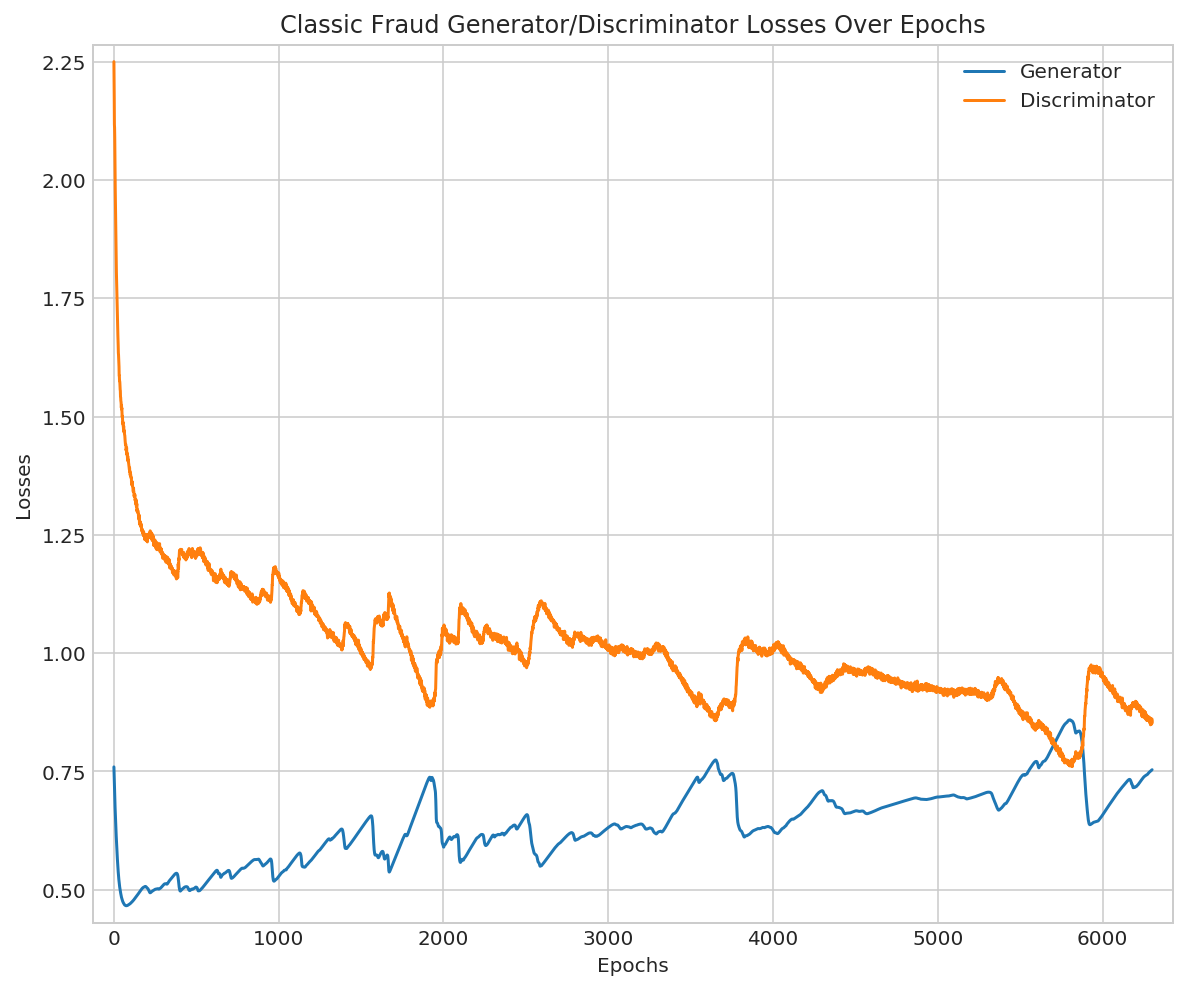

In [19]:
# Plot loss results
epoch_axis = np.linspace(1, gan_epochs, num=gan_epochs)

# Extract generator and discriminator losses from 'gan_fraud' object
gen_losses_fraud = [gen[1] for gen in gan_fraud_loss]
disc_losses_fraud = [disc[0] for disc in gan_fraud_loss]

# Plot discriminator/generator losses of fraud/fraudless beside each other
_ = plt.figure(figsize=(16,7))

_ = plt.subplot(1, 2, 2)
_ = plt.plot(epoch_axis, gen_losses_fraud, label='Generator')
_ = plt.plot(epoch_axis, disc_losses_fraud, label='Discriminator')
_ = plt.xlabel('Epochs'); _ = plt.ylabel('Losses')
_ = plt.legend(loc='best'); _ = plt.title('Classic Fraud Generator/Discriminator Losses Over Epochs')
_ = plt.tight_layout(); plt.margins(0.02)

plt.show()

Interestingly, the losses of the generator rises over epochs while decreases in the discriminator. This could suggest that the discriminator increasingly overpowers the generator over epochs. However, this is a good problem in the sense where the generator is forced to repeatedly generate new variants of synthetic data (thereby exploring more thoroughly the characteristics of the real data's distributions) to fool the discriminator.

Towards the final epoch, the training of the GAN on fraudulent data have losses approaching stabilisation. Data near this epoch could have been used to augment the training set. Nonetheless to set some standards, the GAN optimisation is declared to reach an optimum (or minimally stabilisation) when all losses in a 5% frame of the total epochs executed fluctuate within +/-75% of 1 standard deviation from the median loss recorded.

As the generator and the discriminator each have their own loss values (thus having their own stable frame of epochs), generated data from the latest epoch of the two networks was used.

In [20]:
# Obtain steady epoch for the fraudulent GAN
    # Stabilise within +/-5% of total epochs ran, all epochs within this frame must have losses fluctuating about 0.75 s.d.
dloss_sdy_fraud = steady_epoch(disc_losses_fraud, num_epochs_ran=gan_epochs, sd_fluc_pct=0.75, 
                               scan_frame=int(gan_epochs*0.05), stab_fn=np.median)
gloss_sdy_fraud = steady_epoch(gen_losses_fraud, num_epochs_ran=gan_epochs, sd_fluc_pct=0.75, 
                               scan_frame=int(gan_epochs*0.05), stab_fn=np.median)
fraud_sdy_epoch = int(max(max(dloss_sdy_fraud), max(gloss_sdy_fraud)))

print('Fraud steady epoch: {}'.format(fraud_sdy_epoch))

Steady epoch frame found at epoch 1520 as final
Steady epoch frame found at epoch 1539 as final
Fraud steady epoch: 1539


From above, the steady epoch is found to reside at the 1539th.  For a thorough investigation, the generated data from the final epoch was also used for performance comparisons.

In [21]:
# Truncated X columns; Dropped: 'Time'
wilcox_feat = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 
               'V20', 'V21', 'V24', 'V25', 'V27', 'V28']
# Original training data
true_df = train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22'])

In [22]:
print('\n', '############################################# STEADY EPOCH #############################################')
fraud_steady = pd.DataFrame(gan_fraud_X[fraud_sdy_epoch], columns=wilcox_feat)
fraud_steady['Class'] = 1

gan_data_steady = pd.concat([true_df, fraud_steady], axis='rows')
X_gan_steady = gan_data_steady.drop(columns='Class').as_matrix()
y_gan_steady = gan_data_steady['Class'].as_matrix()

# Perform classification
sgd_clf_gan_steady = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
sgd_clf_gan_steady.fit(X_gan_steady, y_gan_steady)
y_hat_gan_steady = sgd_clf_gan_steady.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                      'Amount', 'V26', 'V22']).as_matrix())
pred_score_gan_steady = sgd_clf_gan_steady.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                         'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score (w/o standardisation) / Steady Epoch: ', pred_score_gan_steady, '\n')
print('Confusion Matrix (w/o standardisation) / Steady Epoch: ', '\n', confusion_matrix(y_test, y_hat_gan_steady), '\n')
print('Classification Report (w/o standardisation) / Steady Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_gan_steady))

print('==========================================================================================================')

# Fit and obtain predictions (with standardisation)
sgd_clf_gan_steady.fit(StandardScaler().fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 
                                                                     'Amount', 'V26', 'V22']).as_matrix()).transform(X_gan_steady), y_gan_steady)
y_hat_gan_steady = sgd_clf_gan_steady.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                      'Amount', 'V26', 'V22']).as_matrix())
pred_score_gan_steady = sgd_clf_gan_steady.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                         'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score (with standardisation) / Steady Epoch: ', pred_score_gan_steady, '\n')
print('Confusion Matrix (with standardisation) / Steady Epoch: ', '\n', confusion_matrix(y_test, y_hat_gan_steady), '\n')
print('Classification Report (with standardisation) / Steady Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_gan_steady))


 ############################################# STEADY EPOCH #############################################
Prediction Score (w/o standardisation) / Steady Epoch:  0.997078733743 

Confusion Matrix (w/o standardisation) / Steady Epoch:  
 [[70896   193]
 [   15    98]] 

Classification Report (w/o standardisation) / Steady Epoch: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.87      1.00      0.58      0.36     71089
          1       0.34      0.87      1.00      0.49      0.58      0.31       113

avg / total       1.00      1.00      0.87      1.00      0.58      0.36     71202

Prediction Score (with standardisation) / Steady Epoch:  0.991109800287 

Confusion Matrix (with standardisation) / Steady Epoch:  
 [[70468   621]
 [   12   101]] 

Classification Report (with standardisation) / Steady Epoch: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1

The outcomes above reveal that although the recall on the minority class improves with re-standardisation of the augmented training set fitted on the pre-augmented training set, the cost of false negatives rises sharply which may not be ideal. Without standardisation, the costs is between 0.32-0.49% but changes to 0.54-0.95% when standardised. 

Though still below the benchmarked 1.47% cost of frauds (as a percentage of revenue), the standardised model provides less room for cost accommodation to other fraud mitigation and investigation methods which were not factored into this study. Moreover, the real data features were already standardised and the generator would have produced synthetically standardised observations. It is not surprising to see that the standardised augmentation fared worse.

In [23]:
print('\n', '############################################# FINAL EPOCH #############################################')
fraud_final = pd.DataFrame(gan_fraud_X[gan_epochs], columns=wilcox_feat)
fraud_final['Class'] = 1

gan_data_final = pd.concat([true_df, fraud_final], axis='rows')
X_gan_final = gan_data_final.drop(columns='Class').as_matrix()
y_gan_final = gan_data_final['Class'].as_matrix()

# Perform classification
sgd_clf_gan_final = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
sgd_clf_gan_final.fit(X_gan_final, y_gan_final)
y_hat_gan_final = sgd_clf_gan_final.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                    'Amount', 'V26', 'V22']).as_matrix())
pred_score_gan_final = sgd_clf_gan_final.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                       'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score (w/o standardisation) / Final Epoch: ', pred_score_gan_final, '\n')
print('Confusion Matrix (w/o standardisation) / Final Epoch: ', '\n', confusion_matrix(y_test, y_hat_gan_final), '\n')
print('Classification Report (w/o standardisation) / Final Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_gan_final))

print('==========================================================================================================')

# Fit and obtain predictions (with standardisation)
sgd_clf_gan_final.fit(StandardScaler().fit_transform(X_gan_final), y_gan_final)
y_hat_gan_final = sgd_clf_gan_final.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                    'Amount', 'V26', 'V22']).as_matrix())
pred_score_gan_final = sgd_clf_gan_final.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                       'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score (with standardisation) / Final Epoch: ', pred_score_gan_final, '\n')
print('Confusion Matrix (with standardisation) / Final Epoch: ', '\n', confusion_matrix(y_test, y_hat_gan_final), '\n')
print('Classification Report (with standardisation) / Final Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_gan_final))


 ############################################# FINAL EPOCH #############################################
Prediction Score (w/o standardisation) / Final Epoch:  0.997078733743 

Confusion Matrix (w/o standardisation) / Final Epoch:  
 [[70895   194]
 [   14    99]] 

Classification Report (w/o standardisation) / Final Epoch: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.88      1.00      0.58      0.36     71089
          1       0.34      0.88      1.00      0.49      0.58      0.32       113

avg / total       1.00      1.00      0.88      1.00      0.58      0.36     71202

Prediction Score (with standardisation) / Final Epoch:  0.978834864189 

Confusion Matrix (with standardisation) / Final Epoch:  
 [[69596  1493]
 [   14    99]] 

Classification Report (with standardisation) / Final Epoch: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00    

Generally from the results above, training set augmented with GAN generated data produced substantial improvements in the result. Essentially, the classifier is able to detect fraudulent transactions better. Though the precision in detecting frauds suffers, it does not degrade dramatically. A misclassification of approximately 200 benign transactions is decent.

Using the best performing model (data augmentation using generated samples from the final epoch), the cost incurred from false negatives (undetected frauds) and manual investigations ranges between 0.31-0.48% as a percentage of revenue. While not as well as the gridsearched baseline (0.35-0.40%) at the upper cost boundary, the model outperforms in terms of the recall on fraudulent cases at 0.88 compared to the gridsearched's recall of 0.75.

Suppose sieving out for fraudulent cases is a priority, the GAN architecture is a viable option to consider, offering increased recall rate on the minority class without the escalation of manual review and false negative costs by too much.

The scatter relations of the top 6 correlated features were next plotted to visualise changes.

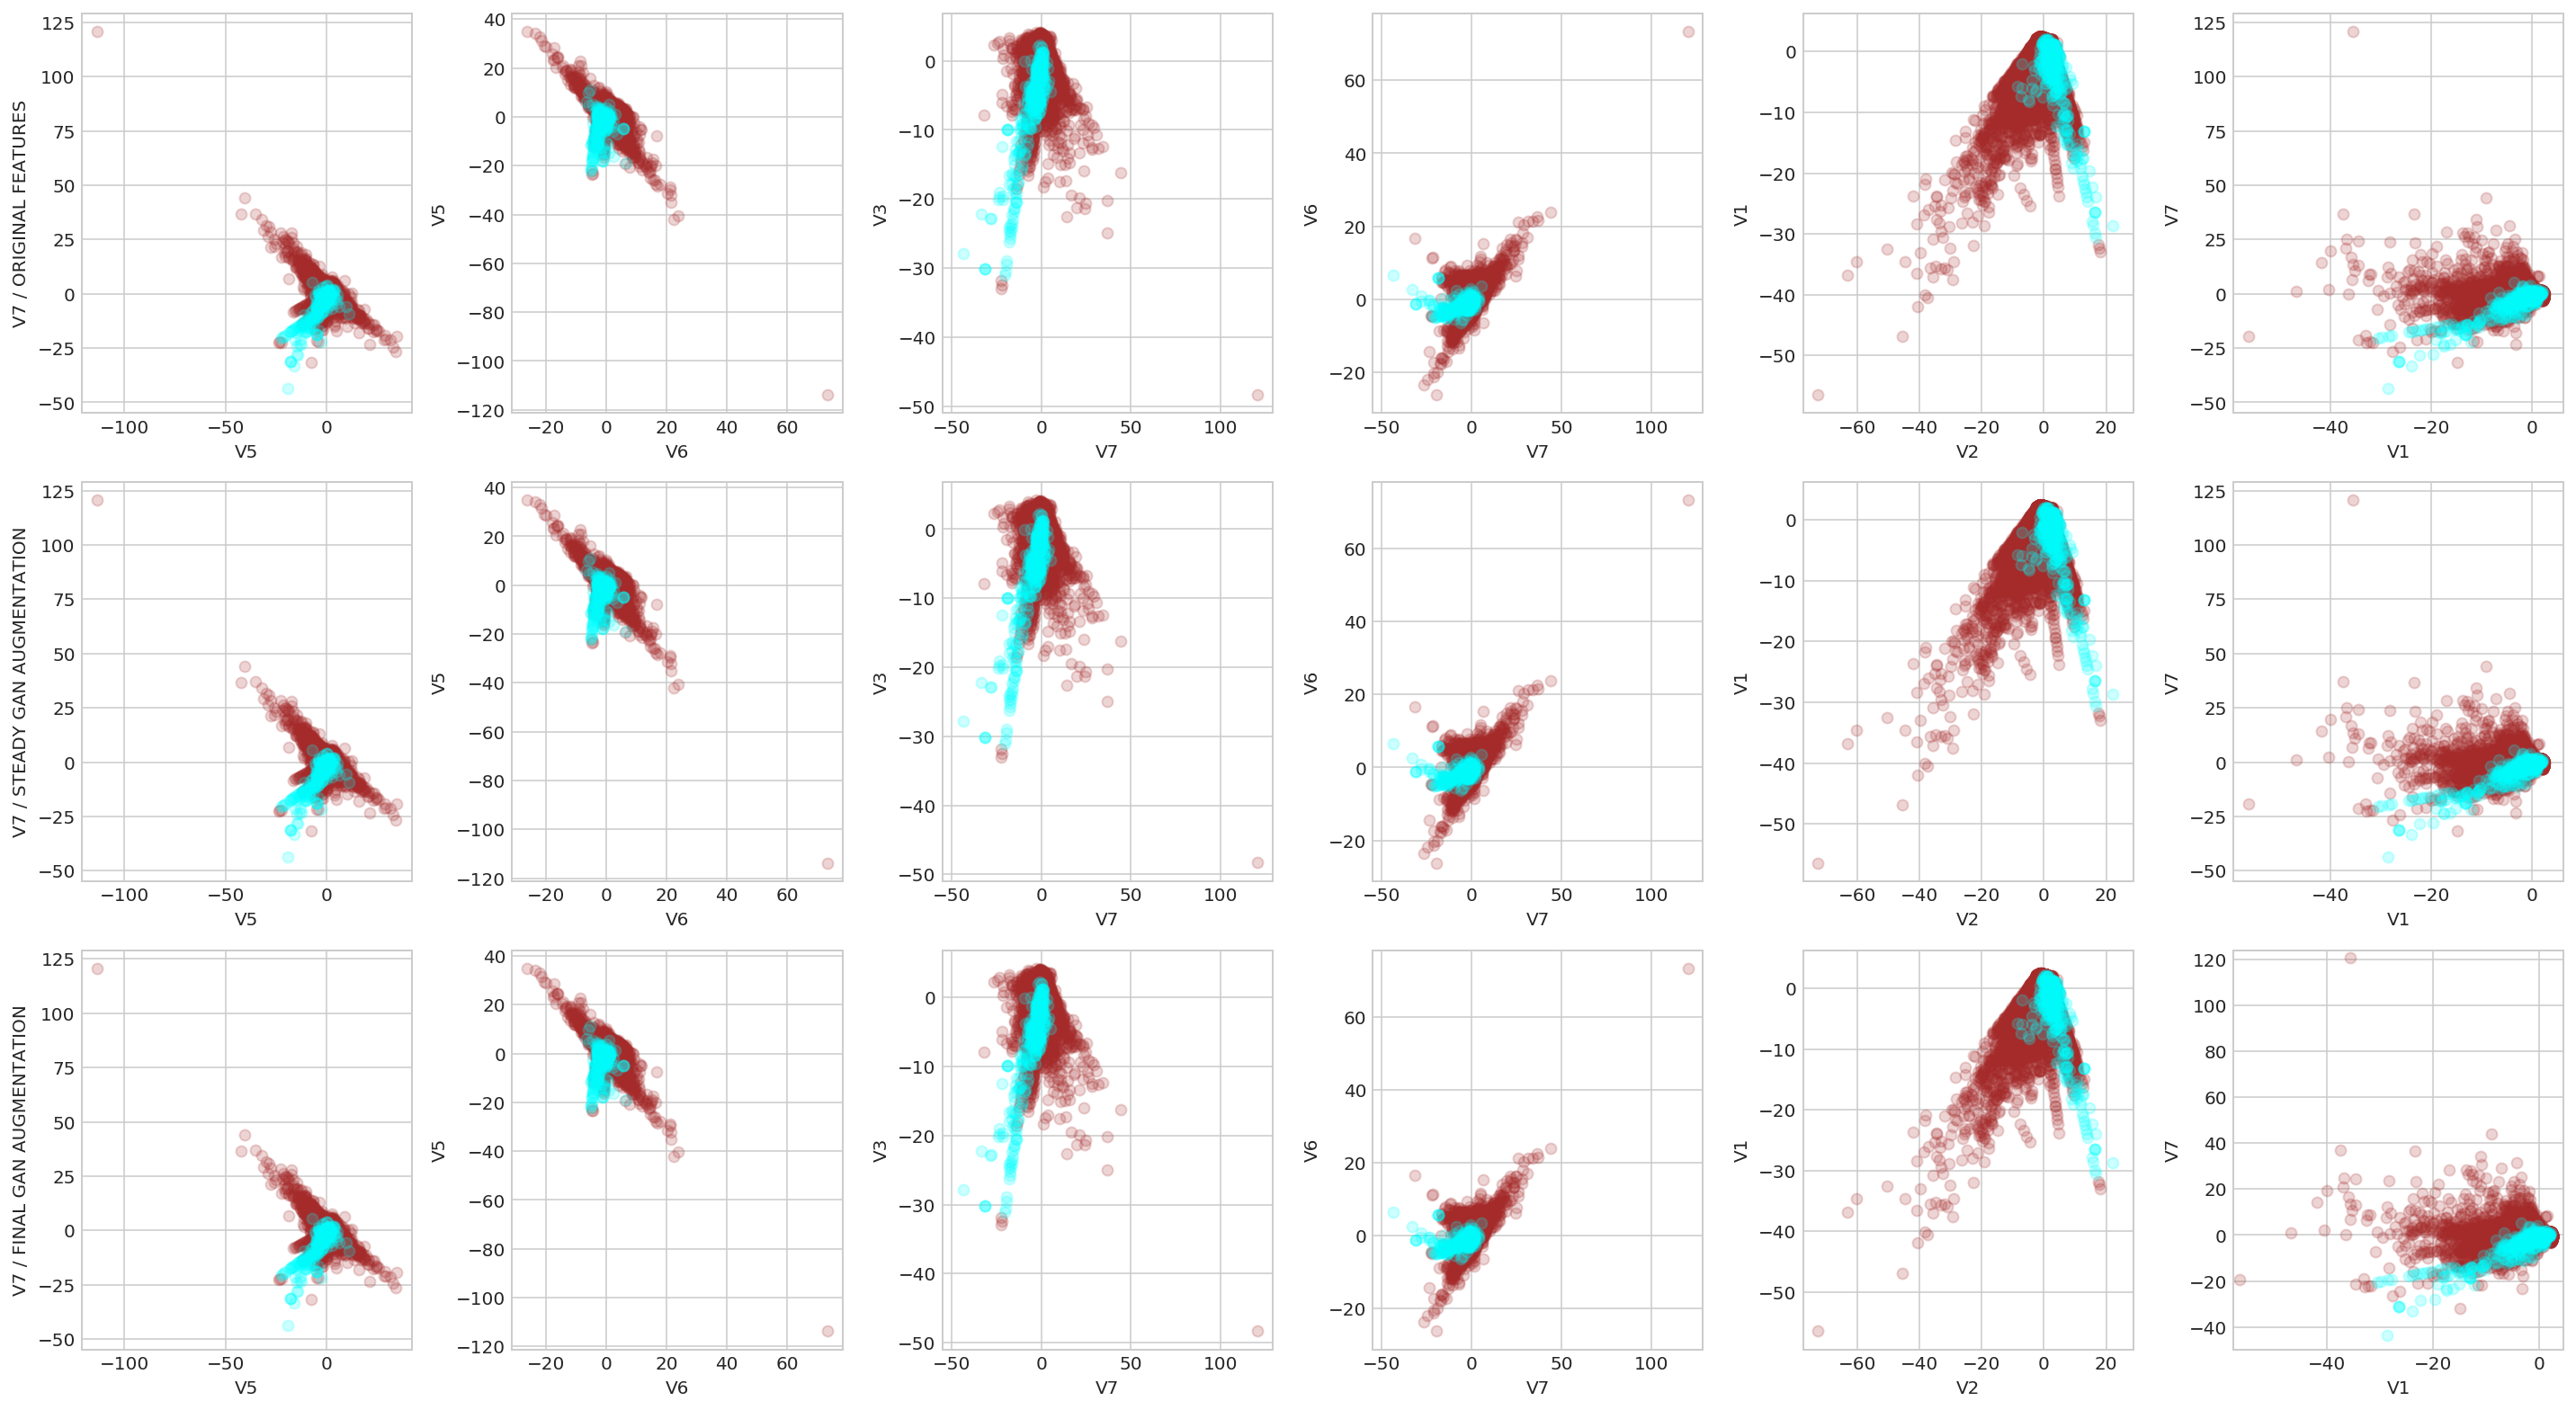

In [19]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(20, 11))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(3, 6, (plot+1))
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / ORIGINAL FEATURES')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(3, 6, (plot+7))
    for group, color, label, in zip(gan_data_steady.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / STEADY GAN AUGMENTATION')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(3, 6, (plot+13))
    for group, color, label, in zip(gan_data_final.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / FINAL GAN AUGMENTATION')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

Effectively, there is little distinction between the pre-augmented training data and the various augmented training set types. Observing close enough, certain areas in the augmented data appears more concentrated but not substantially. This could also be due to augmenting the minority class with just 5000 additional generated datapoints against a total of 213,605 transaction observations in the training set.

Nevertheless, recall that the patterns were distinctively different in the random oversampling and SMOTE model diagrams. This improvement in the classifier's performance is substantial enough to be a viable option for the purpose of minimising the cost of fraud while preventing the level of successful frauds if this methodology is ever deployed.

In the following, the Wasserstein GAN is implemented with slight modifications. In the original implementation, the loss function utilises a root mean-squared error optimisation to both the generator and discriminator's loss functions. However, the adam and stochastic gradient descent optimiser were implemented respectively instead. In addition, the clipping range was modified to between +/-0.05 as opposed to the original +/-0.01 used. Results showed improvements in misclassifications relative to the classical GAN although not dramatically.

In [25]:
# General Parameters

# Inputs
wgan_epochs = 6300
wmini_bat = 5000 # Equivalently wgan_fraudless/fraud.batch_

wX_feats = len(wilcox_feat) # 30 features describing fraud/non-fraud; Equivalently wgan_fraudless/fraud.X_node_
wprior_z_dim = 100 # Draw 100 prior values to feed generator; Equivalently wgan_fraudless/fraud.z_dim_

# Output
wy_outputs = 1 # Equivalently gan_fraudless/fraud.y_node_

# Create GAN objects for fraud data
# From previous trials, reduce the number of connected nodes per layer in the discriminator as it severly overpowers the generator
wgan_fraud = WassersteinGAN(batches=wmini_bat, X_nodes=wX_feats, y_nodes=wy_outputs, z_dims=wprior_z_dim, orig_loss_fn=True)
wgan_fraud.generator()
wgan_fraud.discriminator()
wgan_fraud.optimise()

In [16]:
seed = 42
random.seed(seed)
tf.set_random_seed(seed)
np.random.seed(seed)

# Measure Start Time
start_time = time.time()

### Training phase ###
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    # Collect list of generator/discriminator losses
    wgan_fraud_loss = []
    
    # Collect generated fraudless/fraud data; Epoch as key, array as values
    wgan_fraud_X = {}
    
    ## Execute training epochs ##
    for epoch in range(wgan_epochs):
        
        # Feed X mini-batch
        # Drop following variable 'Time'
        wsplit_df_dict = uniform_draw_feat_class(train_df, 'Class', wmini_bat)
        wfraud_X_mb = wsplit_df_dict[1].drop(columns=['V15', 'V13', 'V23', 
                                                      'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)
        
        # Feed prior(z)
        wfraud_z_sample = np.random.normal(size=[wmini_bat, wprior_z_dim]).astype(np.float32)
        
        # Minimise Losses
        _, wfraud_dloss = sess.run([wgan_fraud.d_trainer_, wgan_fraud.d_loss_], 
                                      feed_dict={wgan_fraud.X_: wfraud_X_mb, 
                                                 wgan_fraud.prior_z_: wfraud_z_sample})
        fraud_dclip = sess.run(wgan_fraud.clip_dis_) # Extracted from above
        _, wfraud_gloss = sess.run([wgan_fraud.g_trainer_, wgan_fraud.g_loss_], 
                                      feed_dict={wgan_fraud.X_: wfraud_X_mb,
                                                 wgan_fraud.prior_z_: wfraud_z_sample})
        
        # Store losses per epoch
        wgan_fraud_loss.append((wfraud_dloss, wfraud_gloss))
        
        if (epoch+1) % 100 == 0 or (epoch+1) == 1:
            # Print generator, discriminator losses for fraudless & fraud cases
            print('Epoch: {}'.format(epoch+1))
            print('Fraud Wasserstein generator loss: {} | Wasserstein discriminator loss: {}'.format(wfraud_gloss, wfraud_dloss), '\n')
        
        # Store generated data
        wfraud_z_gen = np.random.normal(size=[wmini_bat, wprior_z_dim]).astype(np.float32)
        wgan_fraud_X[epoch+1] = sess.run(wgan_fraud.gen_X_, feed_dict={wgan_fraud.prior_z_: wfraud_z_gen})
        
# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

Epoch: 1
Fraud Wasserstein generator loss: 0.7107545733451843 | Wasserstein discriminator loss: 2.250194549560547 

Epoch: 100
Fraud Wasserstein generator loss: 0.6225800514221191 | Wasserstein discriminator loss: 1.4164230823516846 

Epoch: 200
Fraud Wasserstein generator loss: 0.6100090742111206 | Wasserstein discriminator loss: 1.3316141366958618 

Epoch: 300
Fraud Wasserstein generator loss: 0.6071098446846008 | Wasserstein discriminator loss: 1.2712584733963013 

Epoch: 400
Fraud Wasserstein generator loss: 0.6062192320823669 | Wasserstein discriminator loss: 1.2400001287460327 

Epoch: 500
Fraud Wasserstein generator loss: 0.6071541905403137 | Wasserstein discriminator loss: 1.2105743885040283 

Epoch: 600
Fraud Wasserstein generator loss: 0.6047189235687256 | Wasserstein discriminator loss: 1.1901582479476929 

Epoch: 700
Fraud Wasserstein generator loss: 0.608027458190918 | Wasserstein discriminator loss: 1.1703598499298096 

Epoch: 800
Fraud Wasserstein generator loss: 0.61218

In [ ]:
### Saving data ###
# Pickle, save generator/discrimnator losses
pd.to_pickle(wgan_fraud_loss, 'WGAN_Fraud_Loss.pkl')
    
# Save file into 2 parts
first_half = np.linspace(1, (wgan_epochs/2), (wgan_epochs/2)).tolist()
secnd_half = np.linspace((wgan_epochs/2)+1, wgan_epochs, (wgan_epochs/2)).tolist()

wgan_fraud_X_pt1 = {epoch:wgan_fraud_X[epoch] for epoch in first_half}
wgan_fraud_X_pt2 = {epoch:wgan_fraud_X[epoch] for epoch in secnd_half}
pd.to_pickle(wgan_fraud_X_pt1, 'WGAN_Fraud_X1.pkl')
pd.to_pickle(wgan_fraud_X_pt2, 'WGAN_Fraud_X2.pkl')

In [26]:
### Reading saved data ###
# Generated X
wgan_fraud_X_pt1 = pd.read_pickle('WGAN_Fraud_X1.pkl')
wgan_fraud_X_pt2 = pd.read_pickle('WGAN_Fraud_X2.pkl')

# Rejoin files by updating mutable dictionaries before assignment
wgan_fraud_X_pt1.update(wgan_fraud_X_pt2)
    # Direct assignment will fail - dict. method returns 'None'
wgan_fraud_X = wgan_fraud_X_pt1
    
# WGAN Losses
wgan_fraud_loss = pd.read_pickle('WGAN_Fraud_Loss.pkl')

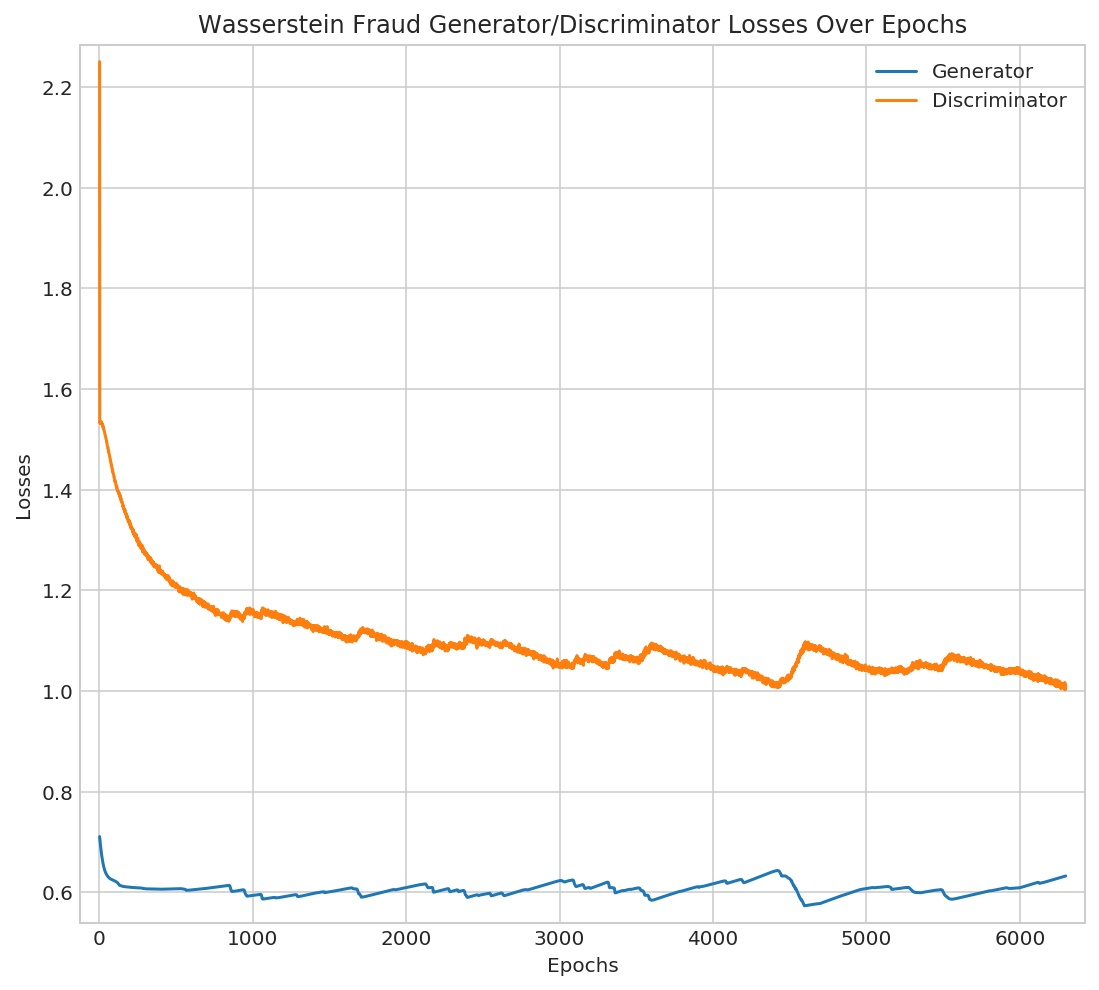

In [27]:
# Plot loss results
epoch_axis = np.linspace(1, wgan_epochs, num=wgan_epochs)

# Extract generator and discriminator losses from 'gan_fraud' object
wgen_losses_fraud = [gen[1] for gen in wgan_fraud_loss]
wdisc_losses_fraud = [disc[0] for disc in wgan_fraud_loss]

# Plot discriminator/generator losses of fraud/fraudless beside each other
_ = plt.figure(figsize=(15,7))

_ = plt.subplot(1, 2, 2)
_ = plt.plot(epoch_axis, wgen_losses_fraud, label='Generator')
_ = plt.plot(epoch_axis, wdisc_losses_fraud, label='Discriminator')
_ = plt.xlabel('Epochs'); _ = plt.ylabel('Losses')
_ = plt.legend(loc='best'); _ = plt.title('Wasserstein Fraud Generator/Discriminator Losses Over Epochs')
_ = plt.tight_layout(); plt.margins(0.02)

plt.show()

When the Lipschitz constraint was imposed, the generator's losses became significantly stable over epochs. This may be good as it potentially signals the generator being given the opportunity to learn the real data's distribution more thoroughly and continuously, avoiding a case of mode collapse. Had mode collapse occurred, the generator's loss would have plunged significantly downwards, or worse, occurring at a very early epoch.

Like the standards set in the GAN implementation, the stable frame is found when 5% of the epochs' losses stabilise within +/-75% of 1 standard deviation from the median loss value.

In [29]:
# Obtain steady epoch for the fraudulent GAN
    # Stabilise within 5% of 6300 epochs ran, all epochs within this frame must have losses fluctuating about 0.75 s.d.
wdloss_sdy_fraud = steady_epoch(wdisc_losses_fraud, num_epochs_ran=wgan_epochs, sd_fluc_pct=0.75, 
                                scan_frame=int(wgan_epochs*0.05), stab_fn=np.median)
wgloss_sdy_fraud = steady_epoch(wgen_losses_fraud, num_epochs_ran=wgan_epochs, sd_fluc_pct=0.75, 
                                scan_frame=int(wgan_epochs*0.05), stab_fn=np.median)
wfraud_sdy_epoch = int(max(max(wdloss_sdy_fraud), max(wgloss_sdy_fraud)))

print('Fraud steady epoch: {}'.format(wfraud_sdy_epoch))

Steady epoch frame found at epoch 1665 as final
Steady epoch frame found at epoch 440 as final
Fraud steady epoch: 1665


In [30]:
# Truncated X columns; Dropped: 'Time'
wilcox_feat = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 
               'V20', 'V21', 'V24', 'V25', 'V27', 'V28']
# Original training data
true_df = train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22'])

In [31]:
print('\n', '############################################# STEADY EPOCH #############################################')
wfraud_steady = pd.DataFrame(wgan_fraud_X[wfraud_sdy_epoch], columns=wilcox_feat)
wfraud_steady['Class'] = 1

wgan_data_steady = pd.concat([true_df, wfraud_steady], axis='rows')
X_wgan_steady = wgan_data_steady.drop(columns='Class').as_matrix()
y_wgan_steady = wgan_data_steady['Class'].as_matrix()

# Perform classification
sgd_clf_wgan_steady = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
sgd_clf_wgan_steady.fit(X_wgan_steady, y_wgan_steady)
y_hat_wgan_steady = sgd_clf_wgan_steady.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                        'Amount', 'V26', 'V22']).as_matrix())
pred_score_wgan_steady = sgd_clf_wgan_steady.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                           'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Wasserstein Prediction Score (w/o standardisation) / Steady Epoch: ', pred_score_wgan_steady, '\n')
print('Wasserstein Confusion Matrix (w/o standardisation) / Steady Epoch: ', '\n', confusion_matrix(y_test, y_hat_wgan_steady), '\n')
print('Wasserstein Classification Report (w/o standardisation) / Steady Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_wgan_steady))

print('==========================================================================================================')

# Fit and obtain predictions (with standardisation)
sgd_clf_wgan_steady.fit(StandardScaler().fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 
                                                                      'Amount', 'V26', 'V22']).as_matrix()).transform(X_wgan_steady), y_wgan_steady)
y_hat_wgan_steady = sgd_clf_wgan_steady.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                        'Amount', 'V26', 'V22']).as_matrix())
pred_score_wgan_steady = sgd_clf_wgan_steady.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                           'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Wasserstein Prediction Score (with standardisation) / Steady Epoch: ', pred_score_wgan_steady, '\n')
print('Wasserstein Confusion Matrix (with standardisation) / Steady Epoch: ', '\n', confusion_matrix(y_test, y_hat_wgan_steady), '\n')
print('Wasserstein Classification Report (with standardisation) / Steady Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_wgan_steady))


 ############################################# STEADY EPOCH #############################################
Wasserstein Prediction Score (w/o standardisation) / Steady Epoch:  0.996643352715 

Wasserstein Confusion Matrix (w/o standardisation) / Steady Epoch:  
 [[70864   225]
 [   14    99]] 

Wasserstein Classification Report (w/o standardisation) / Steady Epoch: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.88      1.00      0.55      0.33     71089
          1       0.31      0.88      1.00      0.45      0.55      0.28       113

avg / total       1.00      1.00      0.88      1.00      0.55      0.33     71202

Wasserstein Prediction Score (with standardisation) / Steady Epoch:  0.991025532991 

Wasserstein Confusion Matrix (with standardisation) / Steady Epoch:  
 [[70464   625]
 [   14    99]] 

Wasserstein Classification Report (with standardisation) / Steady Epoch: 
                    pre       re

In [32]:
print('\n', '############################################# FINAL EPOCH #############################################')
wfraud_final = pd.DataFrame(wgan_fraud_X[wgan_epochs], columns=wilcox_feat)
wfraud_final['Class'] = 1

wgan_data_final = pd.concat([true_df, wfraud_final], axis='rows')
X_wgan_final = wgan_data_final.drop(columns='Class').as_matrix()
y_wgan_final = wgan_data_final['Class'].as_matrix()

# Perform classification
sgd_clf_wgan_final = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
sgd_clf_wgan_final.fit(X_wgan_final, y_wgan_final)
y_hat_wgan_final = sgd_clf_wgan_final.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                      'Amount', 'V26', 'V22']).as_matrix())
pred_score_wgan_final = sgd_clf_wgan_final.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                         'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Wasserstein Prediction Score (w/o standardisation) / Final Epoch: ', pred_score_wgan_final, '\n')
print('Wasserstein Confusion Matrix (w/o standardisation) / Final Epoch: ', '\n', confusion_matrix(y_test, y_hat_wgan_final), '\n')
print('Wasserstein Classification Report (w/o standardisation) / Final Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_wgan_final))

print('==========================================================================================================')

# Fit and obtain predictions (with standardisation)
sgd_clf_wgan_final.fit(StandardScaler().fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 
                                                                     'Amount', 'V26', 'V22']).as_matrix()).transform(X_wgan_final), y_wgan_final)
y_hat_wgan_final = sgd_clf_wgan_final.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                      'Amount', 'V26', 'V22']).as_matrix())
pred_score_wgan_final = sgd_clf_wgan_final.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                         'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Wasserstein Prediction Score (with standardisation) / Final Epoch: ', pred_score_wgan_final, '\n')
print('Wasserstein Confusion Matrix (with standardisation) / Final Epoch: ', '\n', confusion_matrix(y_test, y_hat_wgan_final), '\n')
print('Wasserstein Classification Report (with standardisation) / Final Epoch:', '\n', classification_report_imbalanced(y_test, y_hat_wgan_final))


 ############################################# FINAL EPOCH #############################################
Wasserstein Prediction Score (w/o standardisation) / Final Epoch:  0.997542203871 

Wasserstein Confusion Matrix (w/o standardisation) / Final Epoch:  
 [[70928   161]
 [   14    99]] 

Wasserstein Classification Report (w/o standardisation) / Final Epoch: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.88      1.00      0.62      0.40     71089
          1       0.38      0.88      1.00      0.53      0.62      0.36       113

avg / total       1.00      1.00      0.88      1.00      0.62      0.40     71202

Wasserstein Prediction Score (with standardisation) / Final Epoch:  0.99245807702 

Wasserstein Confusion Matrix (with standardisation) / Final Epoch:  
 [[70565   524]
 [   13   100]] 

Wasserstein Classification Report (with standardisation) / Final Epoch: 
                    pre       rec       

With the results from augmenting data created by WGANs, the steady unstandardized WGAN yield a cost range between 0.33-0.51% while at the final unstandardized epoch, this cost ranges between 0.29-0.44%. Replicating this motif in the vanilla GAN unstandardized models, the steady and final epoch cost ranges are between 0.32-0.49% and 0.31-0.48%.

Through these, results suggest that the classical GAN models possibly require more training epochs before reaching the optimum. Comparing against WGAN, the results substantially improves from the steady to the final epoch by the time the final training epoch is ran. In addition, the precision of WGAN augmented data models appear to be higher than GAN models where the lowest recorded precision for WGAN was at 0.14 while 0.04 in GAN. This serves as an additional piece of evidence suggesting that WGAN would generally be a better architecture over its predecessor.

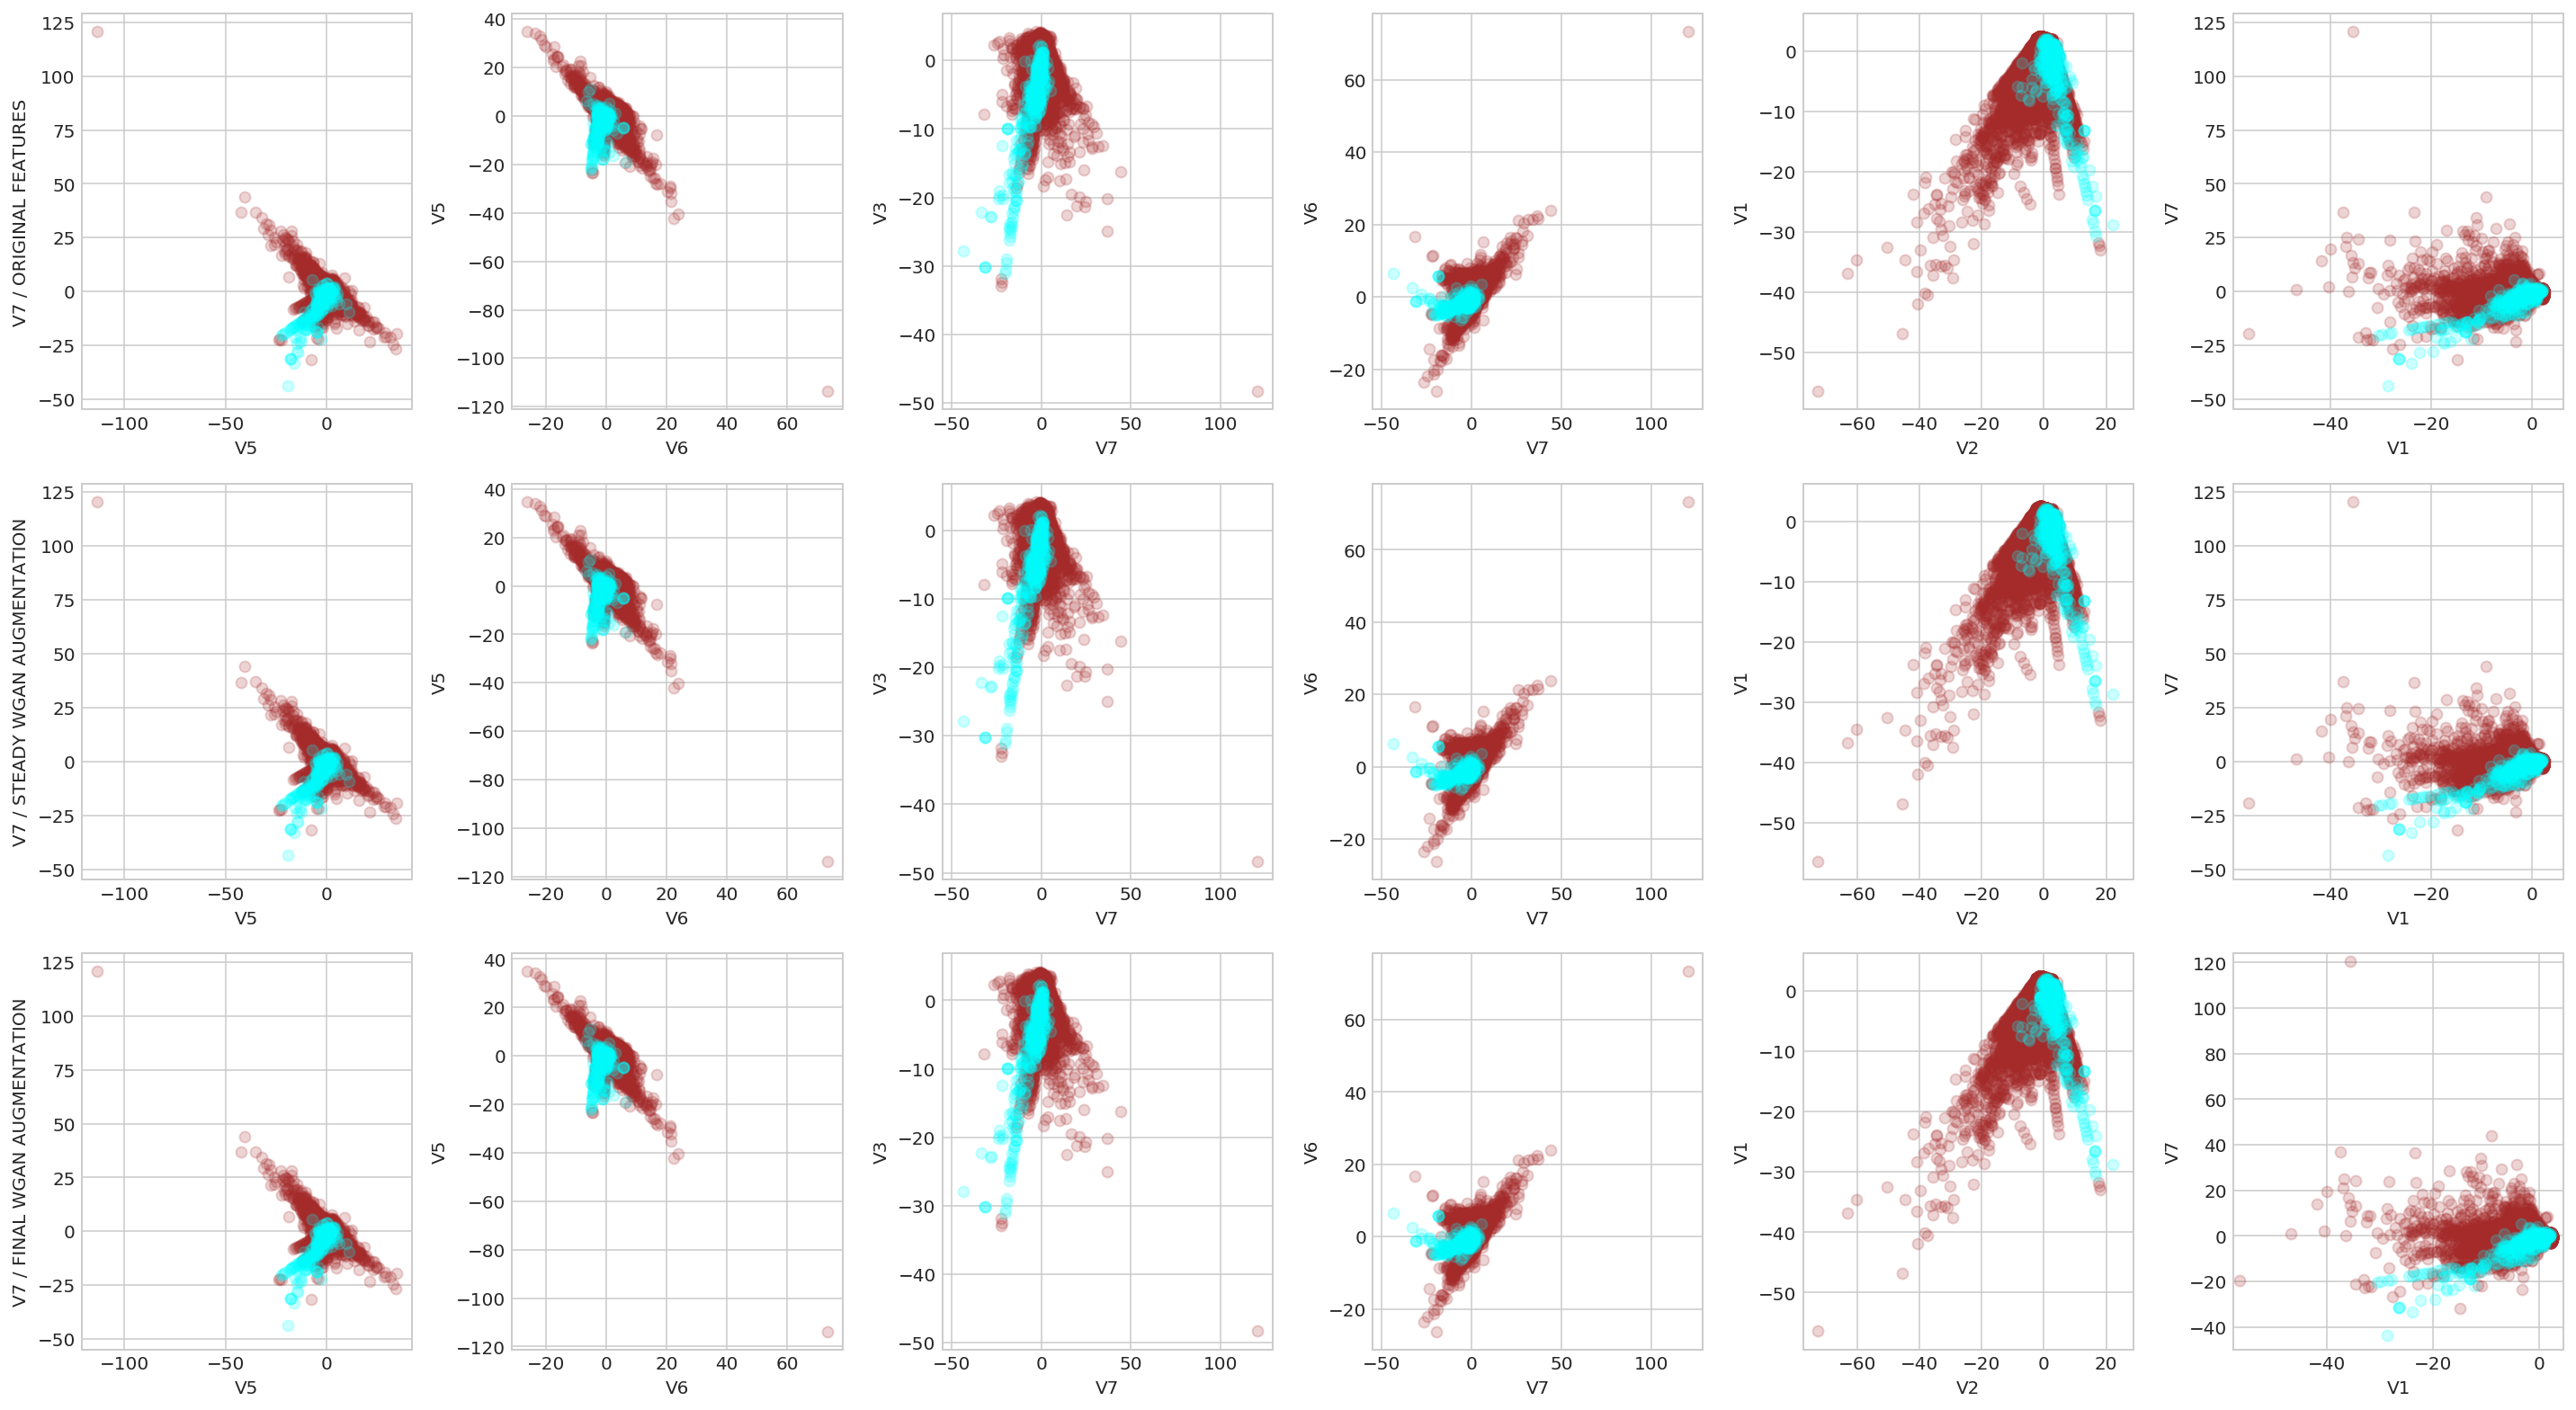

In [33]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(20, 11))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(3, 6, (plot+1))
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / ORIGINAL FEATURES')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(3, 6, (plot+7))
    for group, color, label, in zip(wgan_data_steady.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / STEADY WGAN AUGMENTATION')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(3, 6, (plot+13))
    for group, color, label, in zip(wgan_data_final.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / FINAL WGAN AUGMENTATION')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

Like the data augmentation patterns found in GAN, there is little or near insignificant differences from the pre-augmented training set. Both the GAN and WGAN architectures prove capable of learning the real data's underlying distributions well or do not distort real data distributions when augmented with generated data at the very least.

### Summary of Findings

_**The impact of augmenting data from GANs on the cost of frauds**_


  Model        |  Restd.  |  Precision_fraud    |  Recall_fraud    |  FP  |  TP  |  FN  |  TN  |  Cost_L  |  Cost_U  
---------------|----------|---------------------|------------------|------|------|------|------|----------|----------
Baseline       | No       | 0.06                | 0.91             |1584  |103   |10    |69505 |1.09%     |2.03%
Grid. Baseline | No       | 0.83                | 0.75             |18    |85    |28    |71071 |0.35%     |0.40%
Rand. Ovrsmpl  | No       | 0.04                | 0.91             |2546  |103   |10    |68543 |1.65%     |3.13%
SMOTE          | No       | 0.01                | 0.92             |7398  |104   |9     |63691 |4.47%     |8.67%
SMOTE-TL       | No       | 0.05                | 0.91             |1883  |103   |10    |69206 |1.26%     |2.37%
GAN, Steady    | No       | 0.34                | 0.87             |193   |98    |15    |70896 |0.32%     |0.49%
GAN, Steady    | Yes      | 0.14                | 0.89             |621   |101   |12    |70468 |0.54%     |0.95%
GAN, Final     | No       | 0.34                | 0.88             |194   |99    |14    |70895 |0.31%     |0.48%
GAN, Final     | Yes      | 0.06                | 0.88             |1493  |99    |14    |69596 |1.07%     |1.96%
WGAN, Steady   | No       | 0.31                | 0.88             |225   |99    |14    |70864 |0.33%     |0.51%
WGAN, Steady   | Yes      | 0.14                | 0.88             |625   |99    |14    |70464 |0.57%     |0.97%
WGAN, Final    | No       | 0.38                | 0.88             |161   |99    |14    |70928 |0.29%     |0.44%
WGAN, Final    | Yes      | 0.16                | 0.88             |524   |100   |13    |70565 |0.50%     |0.85%

---

All in all, generative adversarial networks are very successful in learning the real data's distribution rather than duplicating the given data. While the recall on the minority-fraud class suffers relative to the random upsampling and SMOTE data augmentation methods, this value is very small in absolute numbers. 

Further, the precision of the classifiers using GAN generated data perform much better than the vanilla methods. This supports the possible idea that the reason why random oversampling and SMOTE augmented data possess greater recall on frauds is due to the fact that the classifier applies a 'blanket cover' on the entire dataset and is likelier to identify data as frauds (hence the poorer precision). In a simplistic sense, this is akin to defensive strategies - better to err on the side of caution.

However, being defensive is not necessarily the optimal choice. The cost of managing frauds scales together with an increased amount of falsely identified transactions as frauds. In the accompanying [notes](https://github.com/CheoRM/cheorm.github.io/tree/master/accompanying_blog_notes/GAN_Credit_Card_Fraud), it is shown that when methods with higher rates of misclassifications are implemented, the costs of manual reviews become too much to bear such that it is irrational to the business to prevent frauds using these methods.

_**Concluding points**_ <br>
The purpose of choosing GANs to augment data was fundamentally borne out of the consideration of preventing overfitting to the training sets as well as avoiding overfitted classifiers on the test set via gridsearching. Moreover, while not an extensive array of non-deep learning sampling methods were explored, the results above showed that time could potentially be saved from gridsearching as well as searching for the method that augments data well. Moreover, decision trees and ensemble based methods tend to consume extensive resources in order to partition data as well as aggregating results to address overfitting.

Since every dataset is unique, so will the sampling methods likely be changed. Instead of researching for the right classical approach all over, GANs reduce this search effort by primarily learning the distribution of the data and generate samples out of it without incurring the possibility of combinatorial explosion (when gridsearching) or misrepresenting the real minority class(es) feature distributions/scatter patterns during the sampling process. When considering a GAN architecture, the WGAN is the better choice among the two GAN systems explored here for its faster convergence to the global optimum while less susceptible to mode collapsing.

_**Future works...**_ <br>
A large repository of generative models exists. Even more, a wide variation of GANs exists and only the vanilla and Wasserstein versions were implemented in this study. One of the more interesting models that emerged is the hybridisation of autoencoders and generative adversarial networks - the Adversarial Autoencoder (AAE). While not shown here, the performance of an autoencoder did not produce significant differences from random oversampling and SMOTE data augmentation methods employed here. Perhaps by integrating an adversarial factor into autoencoders (on the encoder end), results could be better than GANs implemented here. Find out more about AAE [here](https://arxiv.org/abs/1511.05644).

### References

_**GAN & WGANs**_ <br>
\[1] https://github.com/ckmarkoh/GAN-tensorflow/blob/master/gan.py <br>
\[2] https://github.com/wiseodd/generative-models/blob/master/GAN/vanilla_gan/gan_tensorflow.py <br>
\[3] https://github.com/soumith/ganhacks <br>
\[4] https://arxiv.org/abs/1701.07875 <br>
\[5] https://arxiv.org/abs/1406.2661 <br>
\[6] https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_tensorflow.py <br>
\[7] https://ireneli.eu/2016/11/17/deep-learning-13-understanding-generative-adversarial-network/ <br>

_**Autoencoder & Adversarial Autoencoders**_ <br>
\[8] https://arxiv.org/abs/1511.05644 <br>
\[9] https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb <br>

_**Noteworthy Python Dataset, Library & Tips**_ <br>
\[10] http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html <br>
\[11] https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/ <br>
\[12] https://www.kaggle.com/mlg-ulb/creditcardfraud <br>
\[13] http://www.ulb.ac.be/di/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf <br>

_**Information on Frauds**_ <br>
\[14] https://www.lexisnexis.com/risk/downloads/assets/true-cost-fraud-2016.pdf <br>
\[15] https://www.quora.com/How-much-does-it-cost-issuing-banks-to-investigate-a-credit-card-fraud-case <br>
\[16] https://skodaminotti.com/blog/the-art-of-pricing-a-forensic-investigation-what-will-your-fraud-examination-cost/